# <span style='font-family:"Times New Roman"'> <span styel=''>**COLORECTAL CANCER ANALYSIS**

*Emile Cohen*
    
*June 2020*

**Goal**: In this notebook, we want to understand what makes Colorectal Cancer a textbook case for the patterns we saw, and what are the major subcohorts that drive the signal.

---

In [15]:
%run -i '../../../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
import pickle

data_path = '../../../../../data/'
data_wgd = data_path + 'impact-facets-tp53/processed/wgd/'
data_no_wgd = data_path + 'impact-facets-tp53/processed/no_wgd/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

## Interesting functions

In [95]:
from functools import reduce

def get_hotspots(df: pd.DataFrame, Sample_Type: str, group: list = None, group_type:str = None):
    data = df[df['Sample_Type'] == Sample_Type]
    
    if group and group_type:
        data = data[data[group_type].isin(group)]

    data_1 = get_groupby(data,'tp53_spot_1', 'count'); data_2 = get_groupby(data,'tp53_spot_2', 'count'); data_3 = get_groupby(data,'tp53_spot_3', 'count') ; data_4 = get_groupby(data,'tp53_spot_4', 'count') ; data_5 = get_groupby(data,'tp53_spot_5', 'count') 
    series_data = [data_1,data_2,data_3,data_4,data_5]

    df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,
                                                how='outer'), series_data).fillna(0)

    df_merged.columns = ['count_1', 'count_2', 'count_3', 'count_4', 'count_5']
    df_merged['total'] = df_merged.sum(axis=1)
    df_merged = df_merged.sort_values(by='total', ascending=False)

    df_merged = df_merged.drop('nan')
    
    return df_merged

def get_hotspot_frac(df: pd.DataFrame, group_type:str = None, group: list = None, nb = 10):
    if group_type and group:
        df = df[df[group_type].isin(group)]
    result = [['spot', '#', 'frac']]
    for spot in get_groupby(df, 'tp53_spot_1', 'count').sort_values(by='count', ascending=False).head(nb).index.tolist():
        result.append([spot,df[df['tp53_spot_1'] == spot].frac_genome_altered.shape[0], df[df['tp53_spot_1'] == spot].frac_genome_altered.median()])

    return pd.DataFrame(result)


def boxplot_sampletype(df: pd.DataFrame, group:str, palette, order, metrics: str, figsize= (10,3), title: str = '', title_font: int=12, xlim=[0,1]):
    fig=plt.figure(figsize=figsize)
    ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)

    sns.boxplot(y=metrics, x=group,data=df,ax=ax, dodge=False,order=order, palette=palette).set_title(title, weight='bold', fontsize=title_font)
    
    groupby_ = get_groupby(df,group, 'count')
    
    labels = []
    for element in order:
        labels.append(element + '\n('+ str(groupby_.loc[element].values[0])+')')
    
    
    
    ax.set_xticklabels(labels)
    style(ax)
    ax.set_ylim(xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax


# Let's give a look at medians and statistics

def get_statistics(df: pd.DataFrame, group:str, metrics: str, group_list: list):
    group_1 = df[df[group] == group_list[0]][metrics]
    group_2 = df[df[group] == group_list[1]][metrics]

    median_1 = group_1.median()
    median_2 = group_2.median()

    statistic, p_value = ranksums(group_1.dropna().values,group_2.dropna().values)
    
    results = [['', 'size', metrics],
               [group_list[0], group_1.shape[0], median_1],
               [group_list[1], group_2.shape[0], median_2],
               ['', 'Statistics', 'p-value'],
               ['', statistic, p_value]]


    return pd.DataFrame(results)


def get_major_codrivers(master: pd.DataFrame, maf: pd.DataFrame, head:int = 10, tp53=False):
    samples = master.Tumor_Id.tolist()
    if tp53:
        maf_filtered = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['driver'] == True]
    else:
        maf_filtered = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['driver'] == True][maf['Hugo_Symbol'] != 'TP53']
    h = pd.DataFrame(maf_filtered[['Hugo_Symbol']].groupby(['Hugo_Symbol']).size())
    h.columns = ['count']
    h = h.sort_values(by='count', ascending=False).head(head)
    
    return(h)


def create_co_drivers_table(master: pd.DataFrame, group_type:str,  group_1: str, group_2: str):
    master_group_1 = master[master[group_type] == group_1]
    co_drivers_group_1 = get_major_codrivers(master=master_group_1,
                        maf=maf_cohort_nowgd,
                       head=100)
    co_drivers_group_1['proportion_1'] = co_drivers_group_1.apply(lambda x: 100* round(x['count'] / co_drivers_group_1.sum().values[0], 4), axis=1)
    
    master_group_2 = master[master[group_type] == group_2]
    co_drivers_group_2 = get_major_codrivers(master=master_group_2,
                        maf=maf_cohort_nowgd,
                       head=100)
    co_drivers_group_2['proportion_2'] = co_drivers_group_2.apply(lambda x: 100* round(x['count'] / co_drivers_group_2.sum().values[0], 4), axis=1)
    
    co_drivers_groups = pd.merge(co_drivers_group_1, co_drivers_group_2, on='Hugo_Symbol')
    co_drivers_groups['proportion_1'] = - co_drivers_groups['proportion_1']
    
    return co_drivers_groups

## Master Definition and Filtering

In [6]:
cancer = 'Colorectal Cancer'

In [9]:
master_no_wgd = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
master_wgd = pd.read_pickle(data_path + 'impact-facets-tp53/processed/wgd/master_wgd.pkl')

master_no_wgd_cancer = master_no_wgd[master_no_wgd['Cancer_Type'] == cancer]
master_wgd_cancer = master_wgd[master_wgd['Cancer_Type'] == cancer]

maf_cohort_nowgd = pd.read_csv(data_path + 'impact-facets-tp53/processed/no_wgd/maf_cohort_nowgd.txt', sep='\t').drop('Unnamed: 0', axis=1)
maf_cohort_wgd = pd.read_csv(data_path + 'impact-facets-tp53/processed/wgd/maf_cohort_wgd.txt', sep='\t').drop('Unnamed: 0', axis=1)

# What makes Colorectal Cancer a TextBook Case?

## WGD Proportion

Colorectal Cancer is the third bigger cancer in our cohort. Colorectal Cancer has an average proportion of WGD - around 38%
<img src="wgd_proportion.png" width=700 length=700>

## Cancer Panel

* Colorectal Cancer is one of the most represented cancer in MSK-Impact Cohort.
* Enriched for Primary Samples
* It is enriched for >=1_LOSS subgroup, and shows a depletion of 0_HETLOSS subgroup.
* This difference in subgroup proportion implies that COlorectal is enriched for tp53 bi-allelic state (darker green in the last plot) in both Primary and Metastatic cohorts.

<img src="colorectal_header.png" width=700 length=700>
<img src="colorectal_panel.png" width=1000 length=700>

## Genome Instability

Colorectal Cancer shows a significant difference in Genome Instability between TP53 Mono-Allelic and Bi-Allelic subgroups - and has a lot of samples in both groups.
<img src="pancancer_gi.png" width=1000 length=600>

In the TP53 subgroup Pan Cancer plot that follows, we can see 3 important signals:
* The GI difference between *0_HETLOSS* and *1_WILD_TYPE*, two likely mono-allelic subgroups
* *1_WILD_TYPE* GI is very low compared to other subgroups
* Bi Allelic Subgroups - *>=1_LOSS* and *>=1_cnLOH* - have higher GI  than other subgroups and the difference is significant




<img src="pancancer_gi_sub_b.png" width=1000 length=600>



## Co Drivers

Colorectal Cancer is one of the 2 cancers (Endometrial is the other) that shows a difference in # of co-drivers between *0_HETLOSS* and *1_WILD_TYPE*. This is consitent with the fact that *1_WILD_TYPE* is 'very' stable, thus it does need more co drivers than other subgroups.
<img src="driver_count.png" width=1000 length=600>

# WGD Part

## Subgroup Proportion

In the following cells are the proportions of different groupo levels: on the right Primary samples, on the left Metastatic samples.

<img src="pre_prop.png" width=1000 length=600>
<img src="pre_legend.png" width=200 length=200>

<img src="mut_loh_prop.png" width=1000 length=600>
<img src="mut_loh_legend.png" width=200 length=200>

Key points: 
* Enrichment for Pre WGD TP53 Bi-Allelic samples
* Clear enrichment for TP53 LOH and TP53 mutation samples

## Very High Genome Instability

In WGD cohort, Genome Instability median is above 70% for all cancer types.

We still see difference between TP53 bi-allelic and mono-allelic states but those are not very significant:
<img src="pancancer_gi_wgd.png" width=1000 length=600>

# No WGD Part - Cancer Investigation
In this section, our goal is to find subcohorts that lead the signals observed. Here are the different subcohort we will create:
* Hotspot Analysis: splitting on 273 / 248 / 175 / Missense / Truncated / In Frame
* CCF Analysis
* SNV/INDEL Analysis

## Hotspot Analysis
In this section, we cut our cohort to only keep samples with exactly one TP53 mutation, for simplicity.

In [6]:
master_hotspot = master_no_wgd_cancer[master_no_wgd_cancer['tp53_count'] == 1]

In [7]:
get_hotspot_frac(df=master_hotspot,
                group_type=None,
                group=None)

,0,1,2
0,spot,#,frac
1,273,94,0.3135
2,175,71,0.35
3,248,62,0.306
4,282,48,0.32
5,nan,35,0.307
6,245,32,0.3265
7,213,23,0.304
8,196,21,0.315
9,342,16,0.265


### Entire Cohort

,count
tp53_vc_group_1,
truncated,251
missense,224
273,94
hotspot,94
175,71
248,62
in_frame,16


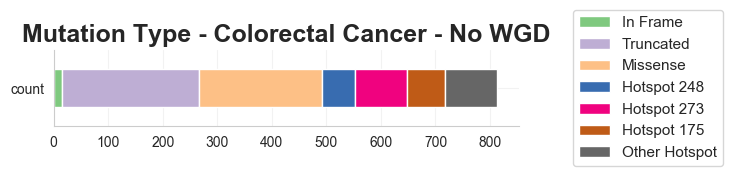

In [8]:
h = get_groupby(master_hotspot,'tp53_vc_group_1', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[mutation_list]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=11)
ax.set_title('Mutation Type - {} - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()

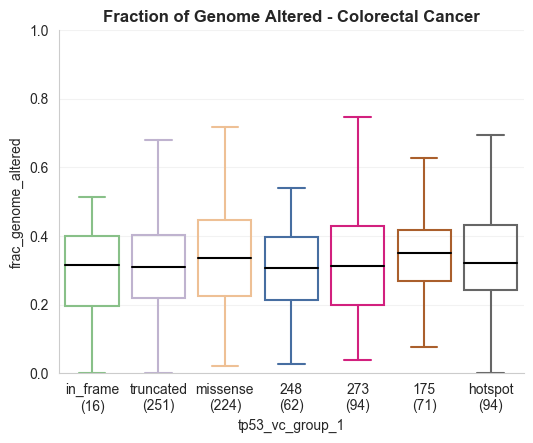

In [9]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='tp53_vc_group_1',
                  palette=mutation_palette,
                  order=mutation_list,
                  metrics='frac_genome_altered',
                  figsize=(6,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

### TP53 Residual Subgroups

In [10]:
print('Number of Bi Allelic samples (with 1 mut): ' + str(master_hotspot[master_hotspot['tp53_res_group'] == 'no_tp53_res'].shape[0]))
print('')
print('Number of  TP53 Residual samples (with 1 mut): ' + str(master_hotspot[master_hotspot['tp53_res_group'] == 'tp53_res'].shape[0]))



Number of Bi Allelic samples (with 1 mut): 708

Number of  TP53 Residual samples (with 1 mut): 92


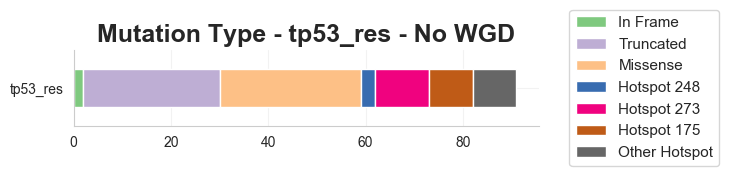

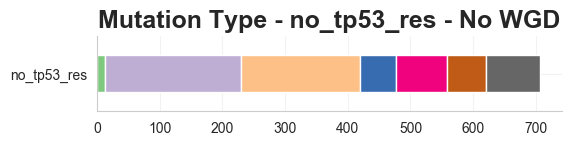

,tp53_res
tp53_vc_group_1,
missense,29
truncated,28
273,11
175,9
hotspot,9
248,3
in_frame,2
,no_tp53_res
tp53_vc_group_1,


In [11]:
total_df = []
for group in ['tp53_res', 'no_tp53_res']:
    h = get_groupby(master_hotspot[master_hotspot['tp53_res_group'] == group], 'tp53_vc_group_1', group).sort_values(by=group, ascending=False)
    total_df.append(h)
    
    h = h.T
    h = h[mutation_list]
    fig = plt.figure(figsize=(6,1))
    ax = plt.subplot()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax, colormap="Accent")
    if group == 'tp53_res':
        ax.legend(['In Frame', 'Truncated', 'Missense', 'Hotspot 248','Hotspot 273','Hotspot 175', 'Other Hotspot'],loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=11)
    else: ax.get_legend().remove()
    ax.set_title('Mutation Type - {} - No WGD'.format(group), weight='bold', fontsize=18)

    plt.show()

display_side_by_side(total_df[0],total_df[1])

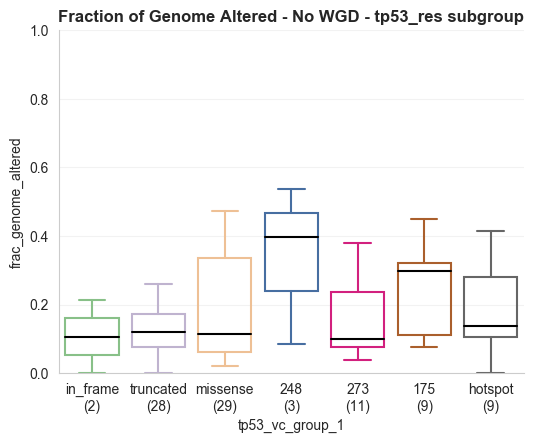

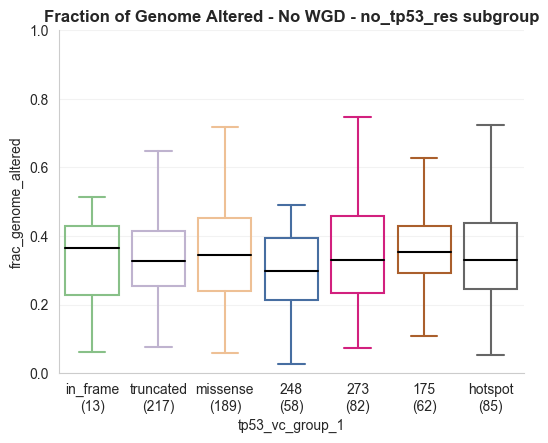

In [12]:
for group in ['tp53_res', 'no_tp53_res']:
    master_wt = master_hotspot[master_hotspot['tp53_res_group'] == group]

    fig, ax = boxplot_sampletype(df=master_wt,
                      group='tp53_vc_group_1',
                      palette=mutation_palette,
                      order=mutation_list,
                      metrics='frac_genome_altered',
                      figsize=(6,10),
                      title='Fraction of Genome Altered - No WGD - {} subgroup'.format(group),
                      xlim=[0,1])
    plt.show()

## SNV / INDEL Analysis
In this section we compare SNV and INDEL mutations. As in the previous section, we cut the cohort to keep only samples with exactly 1 tp53 mutation.

###  # of Drivers / SNV Drivers / INDEL Drivers 

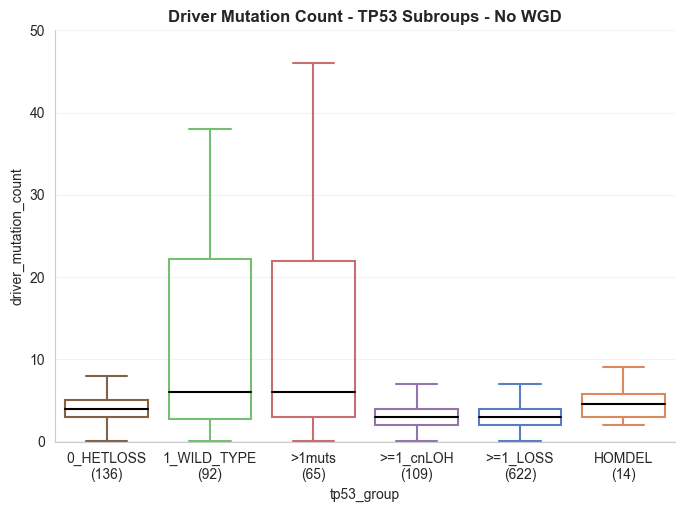

,0,1,2
0,,size,driver_mutation_count
1,1_WILD_TYPE,92,6
2,0_HETLOSS,136,4
3,,Statistics,p-value
4,,3.39615,0.000683411
,0,1,2
0,,size,driver_mutation_count
1,1_WILD_TYPE,92,6
2,>=1_LOSS,622,3
3,,Statistics,p-value


In [13]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='driver_mutation_count',
                  figsize=(8,12),
                  title='Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,50])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

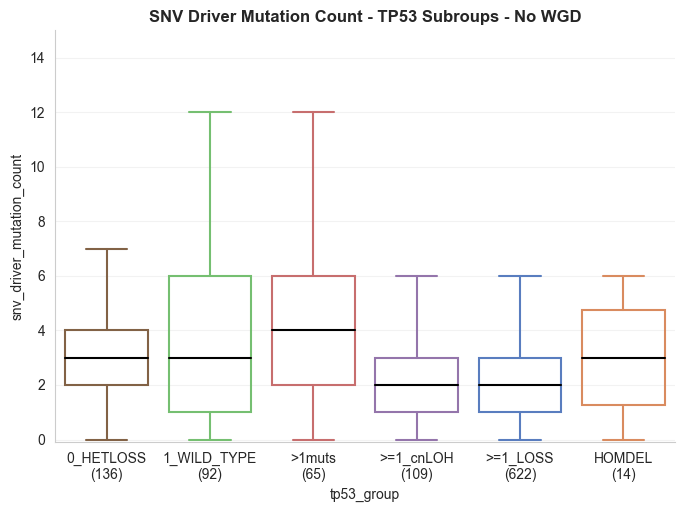

,0,1,2
0,,size,snv_driver_mutation_count
1,1_WILD_TYPE,92,3
2,0_HETLOSS,136,3
3,,Statistics,p-value
4,,1.82138,0.0685498
,0,1,2
0,,size,snv_driver_mutation_count
1,1_WILD_TYPE,92,3
2,>=1_LOSS,622,2
3,,Statistics,p-value


In [14]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='snv_driver_mutation_count',
                  figsize=(8,12),
                  title='SNV Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,15])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='snv_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

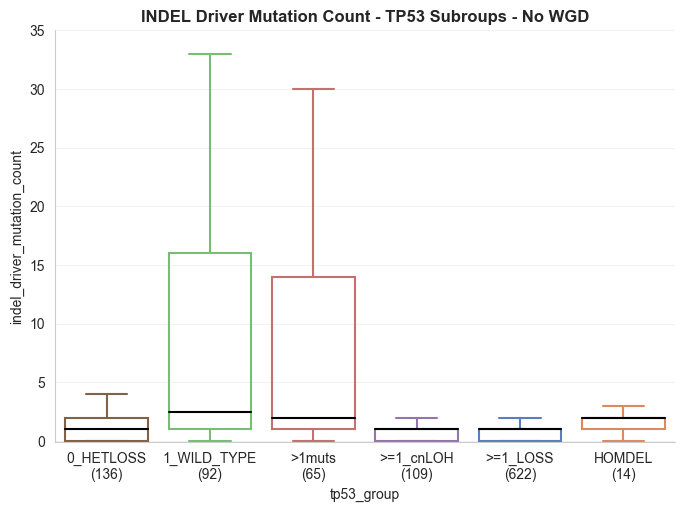

,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,92,2.5
2,0_HETLOSS,136,1
3,,Statistics,p-value
4,,5.1019,3.36264e-07
,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,92,2.5
2,>=1_LOSS,622,1
3,,Statistics,p-value


In [15]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='indel_driver_mutation_count',
                  figsize=(8,12),
                  title='INDEL Driver Mutation Count - TP53 Subroups - No WGD',
                  xlim=[-0.1,35])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

Here, two pieces of information:
* 1. In colorectal Cancer, *1_WILD_TYPE* is enriched in Driver Mutations in comparison with *0_HETLOSS* and even orther bi-allelic subgroups.
* 2.  This signal is led by INDEL Driver Mutation as we see that in SNV Driver Mutations, there is les significant differences between subgroups

### Genome Instability 
The idea here is to see if we have differences in Fraction of Genome Altered if we cut our Cancer cohort on the number of drivers per sample. 

Do we have more instability with more INDEL Driver Mutations within the same subgroup?

#### 1_WILD_TYPE Subgroup

In [16]:
master_no_wgd_cancer_wt = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '1_WILD_TYPE']

thr=6

def get_driver_groups(x):
    if x.driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_wt['co_driver_group'] = master_no_wgd_cancer_wt.apply(get_driver_groups, axis=1)

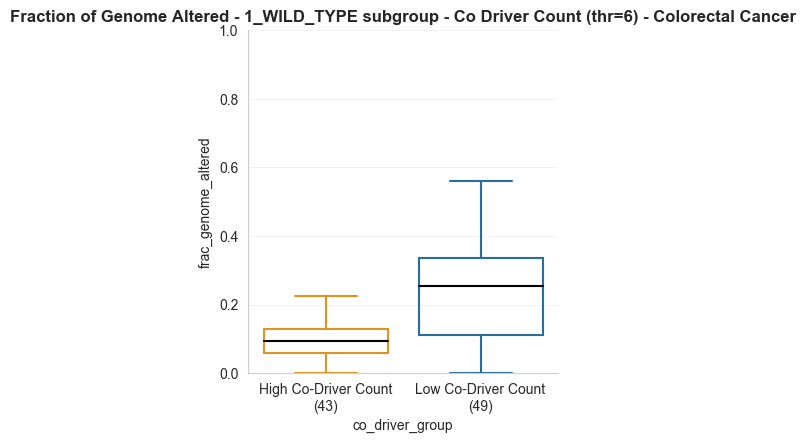

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,43,0.094
2,Low Co-Driver Count,49,0.256
3,,Statistics,p-value
4,,-4.55058,5.34987e-06


In [17]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 1_WILD_TYPE subgroup - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

In [18]:
def plot_density(df: pd.DataFrame, xlabel='', ylabel='', title='',clip = (0,3), group = None,  figsize=(5,5)):
    sns.set_style("whitegrid", {'grid.color': '1.'})
    fig, ax = plt.subplots(figsize=figsize)
    
    
    data =df['tp53_ccf_1']
    ax = sns.distplot(data,kde_kws={'clip': clip, "shade": True}, hist=False)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title('TP53 CCF for 1_WT in Non WGD Samples'  + title + ' (' + str(len(data)) + ')', weight = 'bold')
    
    mean=round(data.mean(),2) ; median=round(data.median(),2)
    string = 'Mean: '+ str(mean) +'\nMedian: ' + str(median)
    ax.axvline(mean, color='g', linestyle='-', label='Mean: '+ str(mean))
    ax.axvline(median, color='b', linestyle='-', label='Median: ' + str(median))
    ax.legend()
    #ax.set_xlim([0,1])
    
    plt.show()

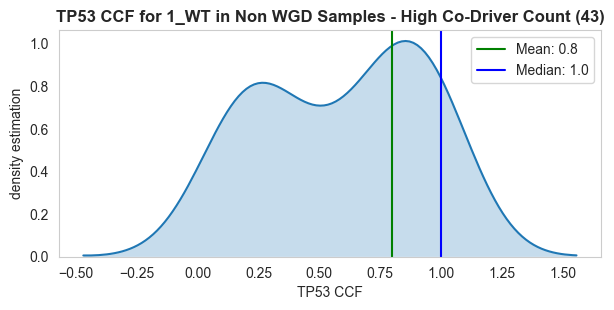

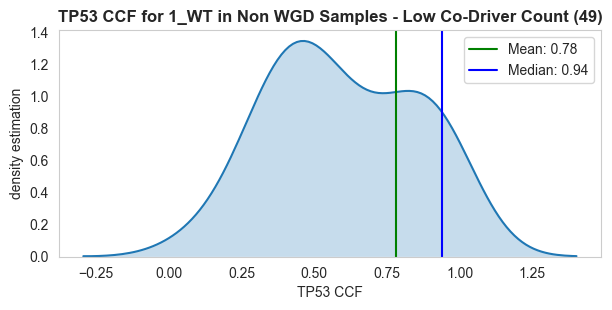

In [19]:
master_high_count = master_no_wgd_cancer_wt[master_no_wgd_cancer_wt['co_driver_group'] == 'High Co-Driver Count']
master_low_count = master_no_wgd_cancer_wt[master_no_wgd_cancer_wt['co_driver_group'] == 'Low Co-Driver Count']

plot_density(df=master_high_count,
             xlabel='TP53 CCF', 
             ylabel='density estimation',
             title=' - High Co-Driver Count',
             clip = (0,1), 
             group = None,  figsize=(7,3))
plt.show()

plot_density(df=master_low_count,
             xlabel='TP53 CCF', 
             ylabel='density estimation',
             title=' - Low Co-Driver Count',
             clip = (0,1), 
             group = None,  figsize=(7,3))

plt.show()

So we see that samples with less co-drivers have a higher Genome Instability

#### 0_HETLOSS

In [20]:
master_no_wgd_cancer_het = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '0_HETLOSS']

thr=0

def get_driver_groups(x):
    if x.indel_driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.indel_driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_het['co_driver_group'] = master_no_wgd_cancer_het.apply(get_driver_groups, axis=1)

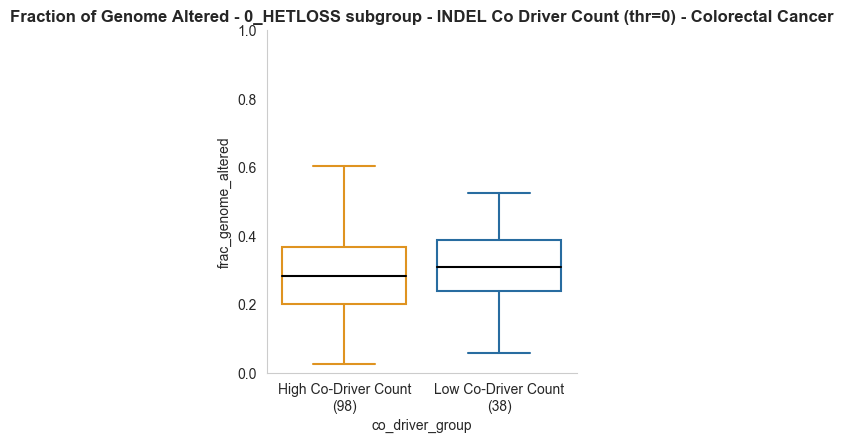

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,98,0.283
2,Low Co-Driver Count,38,0.3095
3,,Statistics,p-value
4,,-0.518931,0.603809


In [21]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_het,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 0_HETLOSS subgroup - INDEL Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_het,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

### Low CCF Analysis

In [23]:
thr_ccf_1 = 0.9

def ccf_subgroup(x):
    if x.tp53_ccf_1 <= thr_ccf_1: return 'low'
    elif x.tp53_ccf_1 > thr_ccf_1: return 'high'

master_no_wgd_cancer['ccf_group'] = master_no_wgd_cancer.apply(ccf_subgroup, axis=1)
get_groupby(master_no_wgd_cancer, 'ccf_group', 'count')

,count
ccf_group,
high,663
low,232


In [24]:
pd.DataFrame(master_no_wgd_cancer[['ccf_group', 'tp53_group']].groupby([ 'tp53_group', 'ccf_group']).size())

0
tp53_group  ccf_group     
1_WILD_TYPE high        53
            low         37
>1muts      high        34
            low         29
>=1_LOSS    high       492
            low        130
>=1_cnLOH   high        81
            low         28
HOMDEL      high         1
            low          6

In [25]:
master_no_wgd_cancer_low = master_no_wgd_cancer[(master_no_wgd_cancer['ccf_group'] == 'low') | (master_no_wgd_cancer['tp53_count'] == 0)]
get_groupby(master_no_wgd_cancer_low, 'tp53_group', 'count')

,count
tp53_group,
0_HETLOSS,136
1_WILD_TYPE,37
>1muts,29
>=1_LOSS,130
>=1_cnLOH,28
HOMDEL,12


#### # of Drivers 

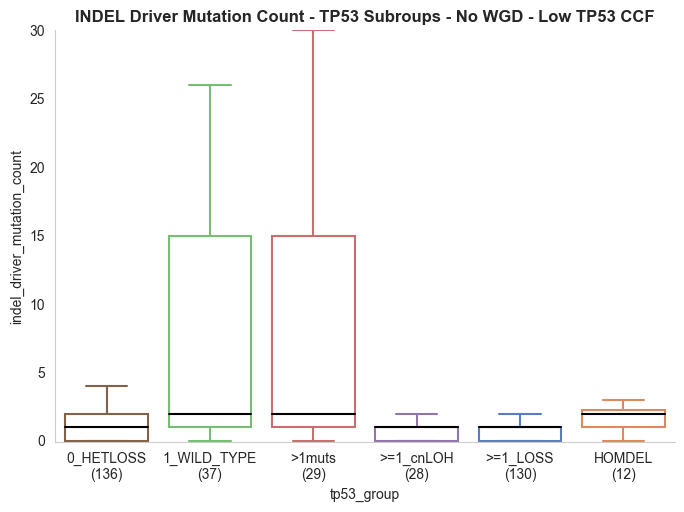

,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,37,2
2,0_HETLOSS,136,1
3,,Statistics,p-value
4,,3.18934,0.00142598
,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,37,2
2,>=1_LOSS,130,1
3,,Statistics,p-value


In [26]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_low,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='indel_driver_mutation_count',
                  figsize=(8,12),
                  title='INDEL Driver Mutation Count - TP53 Subroups - No WGD - Low TP53 CCF',
                  xlim=[-0.1,30])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer_low,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer_low,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer_low,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

#### GI in 1_WILD_TYPE

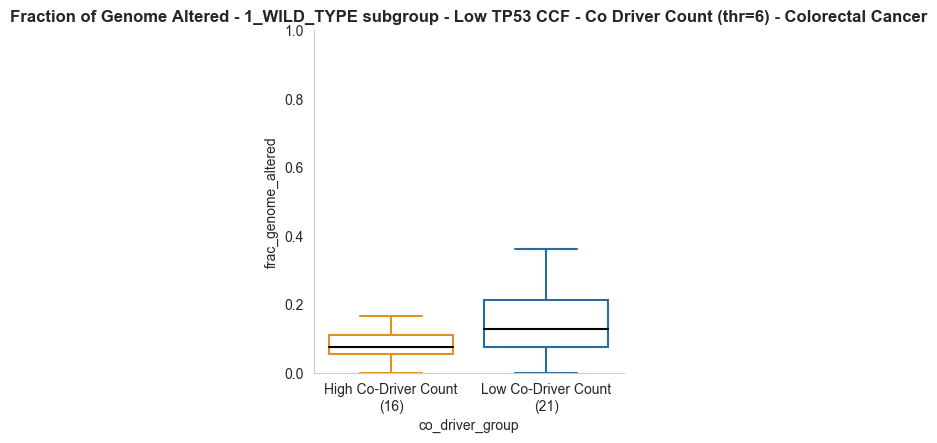

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,16,0.076
2,Low Co-Driver Count,21,0.128
3,,Statistics,p-value
4,,-1.83942,0.0658537


In [27]:
master_no_wgd_cancer_low_wt = master_no_wgd_cancer_low[master_no_wgd_cancer_low['tp53_group'] == '1_WILD_TYPE']

thr=6

def get_driver_groups(x):
    if x.driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_low_wt['co_driver_group'] = master_no_wgd_cancer_low_wt.apply(get_driver_groups, axis=1)

fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_low_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 1_WILD_TYPE subgroup - Low TP53 CCF - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_low_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

### High CCF Analysis

In [28]:
master_no_wgd_cancer_high = master_no_wgd_cancer[(master_no_wgd_cancer['ccf_group'] == 'high') | (master_no_wgd_cancer['tp53_count'] == 0)]
get_groupby(master_no_wgd_cancer_high, 'tp53_group', 'count')

,count
tp53_group,
0_HETLOSS,136
1_WILD_TYPE,53
>1muts,34
>=1_LOSS,492
>=1_cnLOH,81
HOMDEL,7


#### # of Drivers  

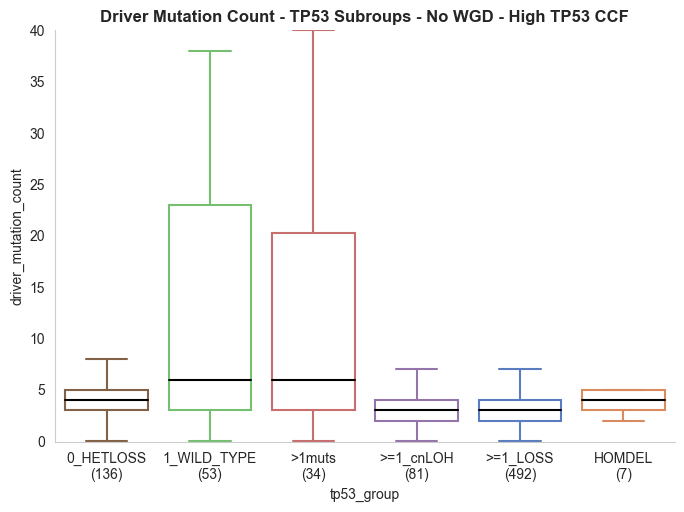

,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,53,4
2,0_HETLOSS,136,1
3,,Statistics,p-value
4,,4.63256,3.61177e-06
,0,1,2
0,,size,indel_driver_mutation_count
1,1_WILD_TYPE,53,4
2,>=1_LOSS,492,1
3,,Statistics,p-value


In [29]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_high,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='driver_mutation_count',
                  figsize=(8,12),
                  title='Driver Mutation Count - TP53 Subroups - No WGD - High TP53 CCF',
                  xlim=[-0.1,40])
plt.show()

display_side_by_side(get_statistics(df=master_no_wgd_cancer_high,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '0_HETLOSS']),
       
       get_statistics(df=master_no_wgd_cancer_high,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['1_WILD_TYPE', '>=1_LOSS']),
        
       get_statistics(df=master_no_wgd_cancer_high,
               group='tp53_group',
               metrics='indel_driver_mutation_count', 
               group_list=['>1muts', '>=1_LOSS']))

#### GI in 1_WILD_TYPE

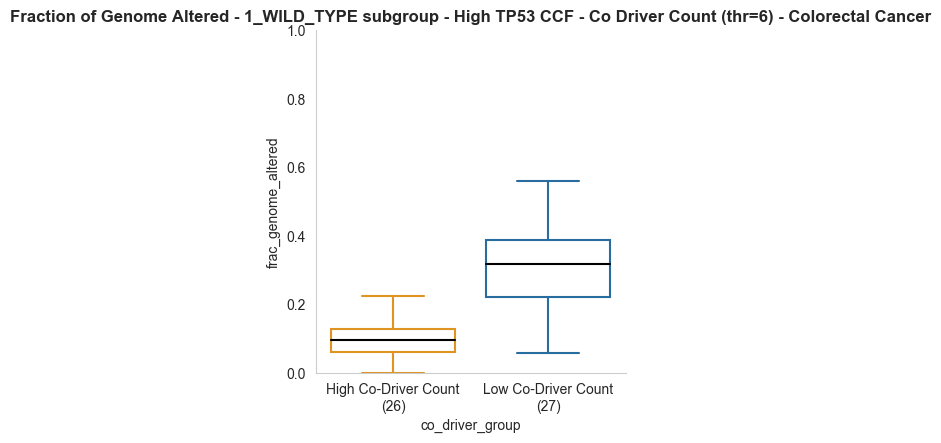

,0,1,2
0,,size,frac_genome_altered
1,High Co-Driver Count,26,0.098
2,Low Co-Driver Count,27,0.318
3,,Statistics,p-value
4,,-4.86612,1.13812e-06


In [30]:
master_no_wgd_cancer_high_wt = master_no_wgd_cancer_high[master_no_wgd_cancer_high['tp53_group'] == '1_WILD_TYPE']

thr=6

def get_driver_groups(x):
    if x.driver_mutation_count > thr:
        return 'High Co-Driver Count'
    if x.driver_mutation_count <= thr:
        return 'Low Co-Driver Count'
    

master_no_wgd_cancer_high_wt['co_driver_group'] = master_no_wgd_cancer_high_wt.apply(get_driver_groups, axis=1)

fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_high_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='frac_genome_altered',
                  figsize=(4,10),
                  title='Fraction of Genome Altered - 1_WILD_TYPE subgroup - High TP53 CCF - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_no_wgd_cancer_high_wt,
               group='co_driver_group',
               metrics='frac_genome_altered',
               group_list=['High Co-Driver Count', 'Low Co-Driver Count'])

In [33]:
get_hotspot_frac(df=master_no_wgd_cancer_high_wt[master_no_wgd_cancer_high_wt['co_driver_group'] == 'High Co-Driver Count'],
                group_type=None,
                group=None)

,0,1,2
0,spot,#,frac
1,90,3,0.089
2,382,3,0.153
3,273,3,0.094
4,342,2,0.0855
5,248,1,0.084
6,73,1,0
7,394,1,0.281
8,282,1,0.106
9,249,1,0.036


In [34]:
get_hotspot_frac(df=master_no_wgd_cancer_high_wt[master_no_wgd_cancer_high_wt['co_driver_group'] == 'Low Co-Driver Count'],
                group_type=None,
                group=None)

,0,1,2
0,spot,#,frac
1,175,5,0.303
2,273,4,0.302
3,135,2,0.341
4,151,2,0.4435
5,248,2,0.467
6,282,2,0.3425
7,nan,2,0.395
8,132,1,0.337
9,138,1,0.174


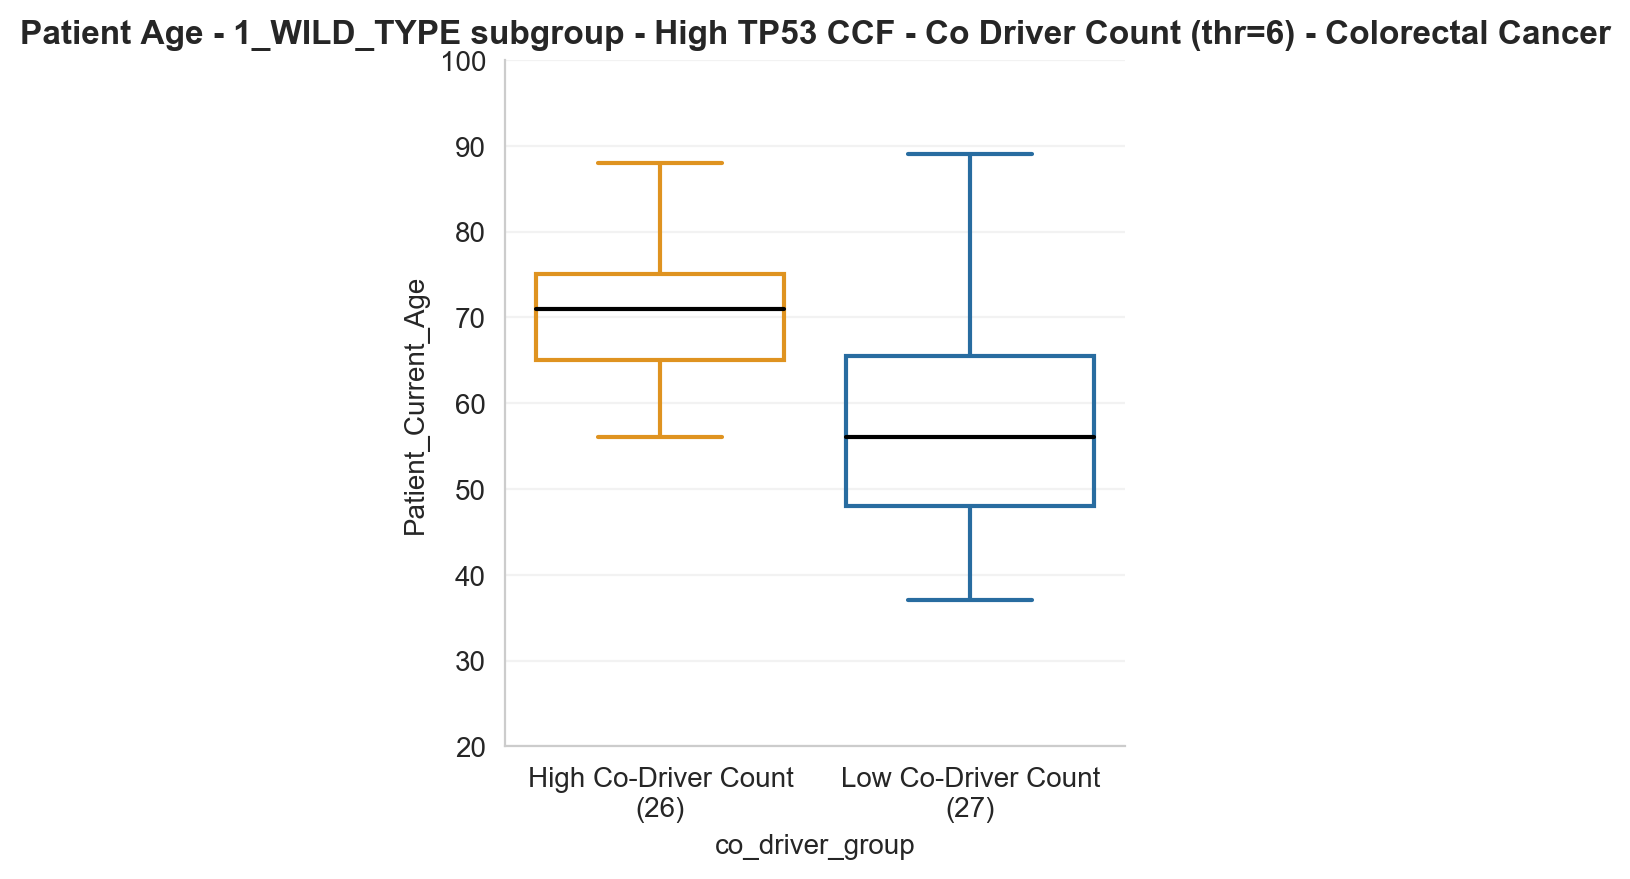

In [53]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer_high_wt,
                  group='co_driver_group',
                  palette={'High Co-Driver Count': '#FF9900' , 'Low Co-Driver Count': '#146EB4'},
                  order=['High Co-Driver Count', 'Low Co-Driver Count'],
                  metrics='Patient_Current_Age',
                  figsize=(4,10),
                  title='Patient Age - 1_WILD_TYPE subgroup - High TP53 CCF - Co Driver Count (thr={}) - {}'.format(thr,cancer),
                  xlim=[20,100])
plt.show()



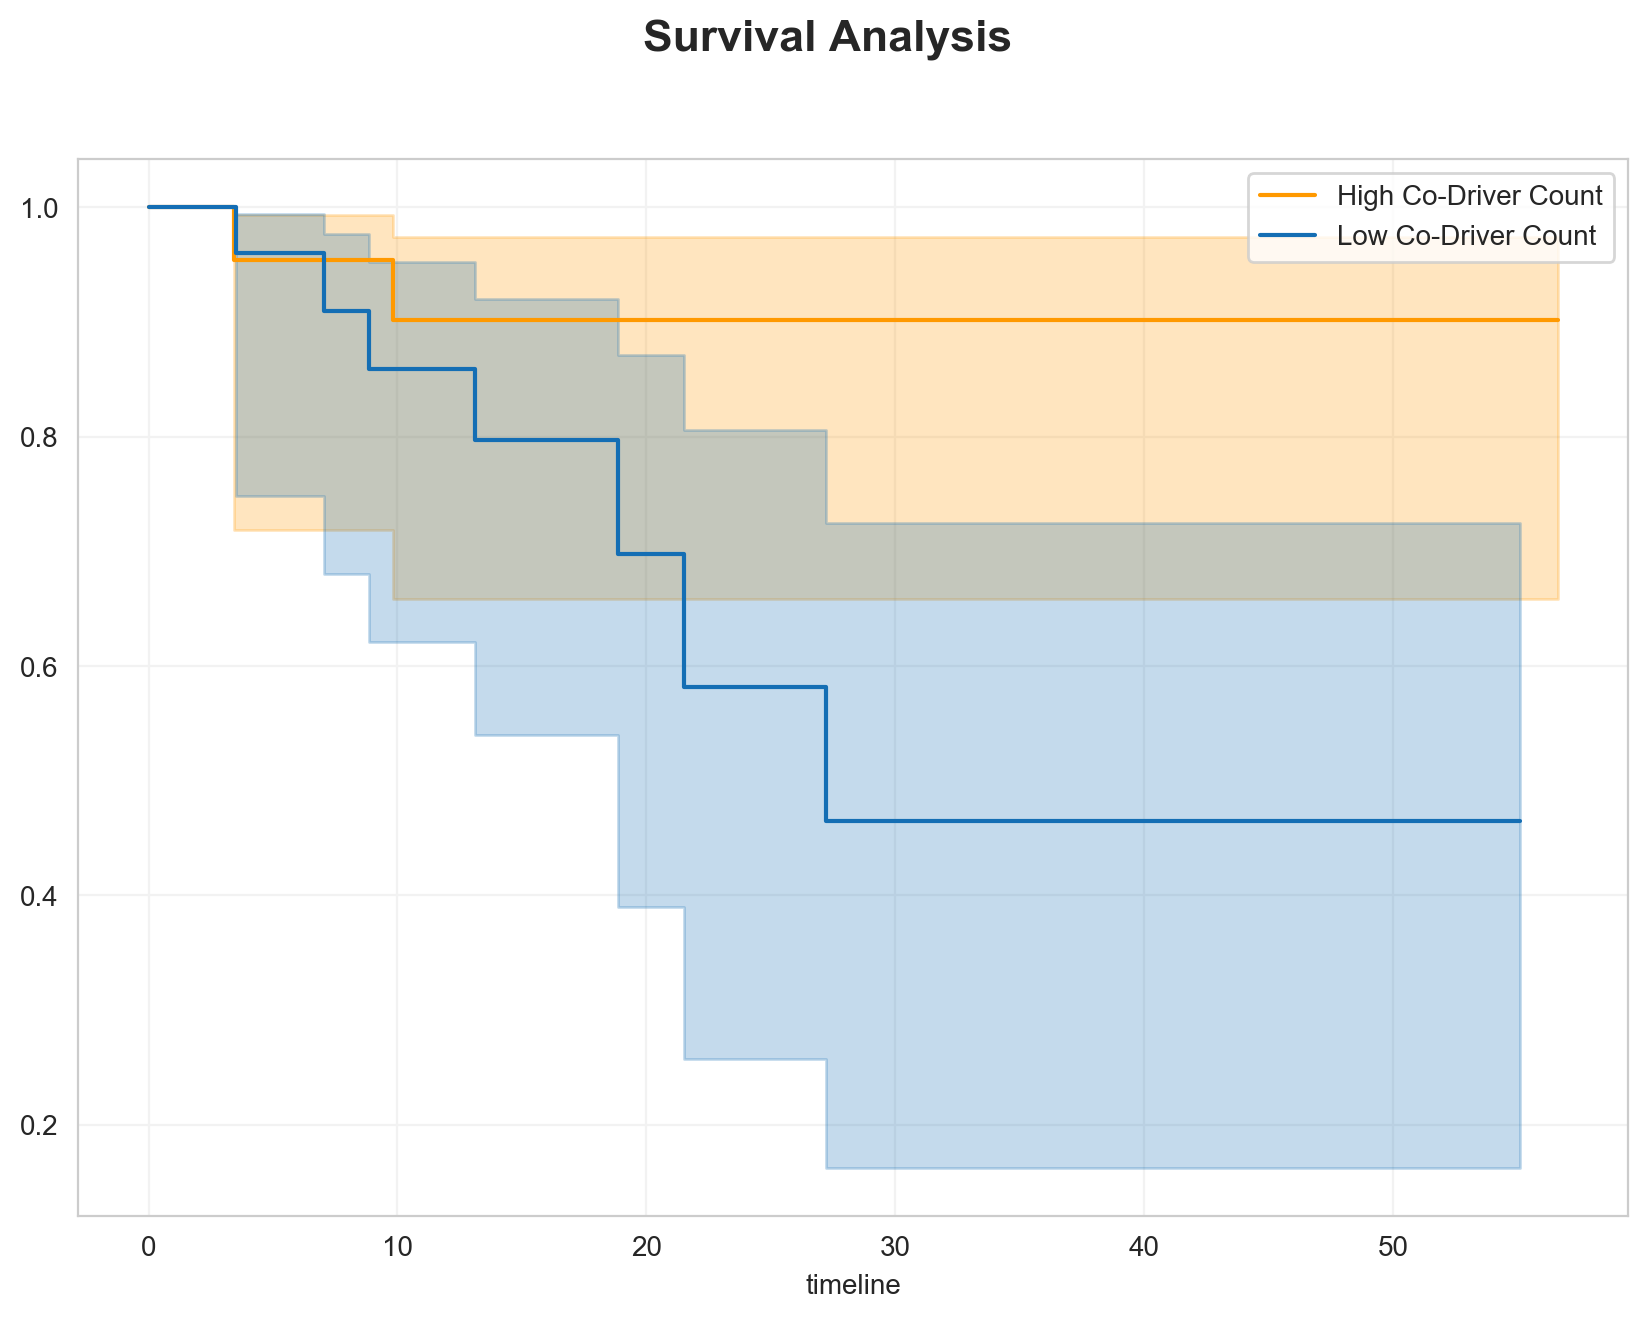

In [69]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis', fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(['High Co-Driver Count', 'Low Co-Driver Count'], range(len(['High Co-Driver Count', 'Low Co-Driver Count']))):
    data = master_no_wgd_cancer_high_wt[master_no_wgd_cancer_high_wt['co_driver_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = ['#FF9900' ,'#146EB4'][i], ax=ax)
plt.show()

## Co Driver Analysis

In [10]:
codrivers_cancer = get_major_codrivers(master=master_no_wgd_cancer,
                    maf=maf_cohort_nowgd,
                    head=15)

codrivers_cancer_tp53 = get_major_codrivers(master=master_no_wgd_cancer[master_no_wgd_cancer['tp53_count'] >= 1],
                    maf=maf_cohort_nowgd,
                    head=15)

In [11]:
co_drivers = pd.merge(codrivers_cancer, codrivers_cancer_tp53, on='Hugo_Symbol')
co_drivers.columns = ['cancer', 'cancer_tp53']

In [12]:
co_drivers['ratio'] = co_drivers.apply(lambda x: 100*round(x.cancer_tp53/x.cancer, 4) , axis=1)
co_drivers = co_drivers.sort_values(by='ratio', ascending=False)

In [13]:
co_drivers

,cancer,cancer_tp53,ratio
Hugo_Symbol,,,
APC,1654,1010,61.06
SMAD4,227,130,57.27
BRAF,186,101,54.30
FBXW7,247,134,54.25
KRAS,741,391,52.77
AMER1,120,58,48.33
PIK3CA,404,176,43.56
PTEN,185,76,41.08
RNF43,205,79,38.54


Text(0.5, 1.0, 'Co-Drivers Enrichment in TP53 State')

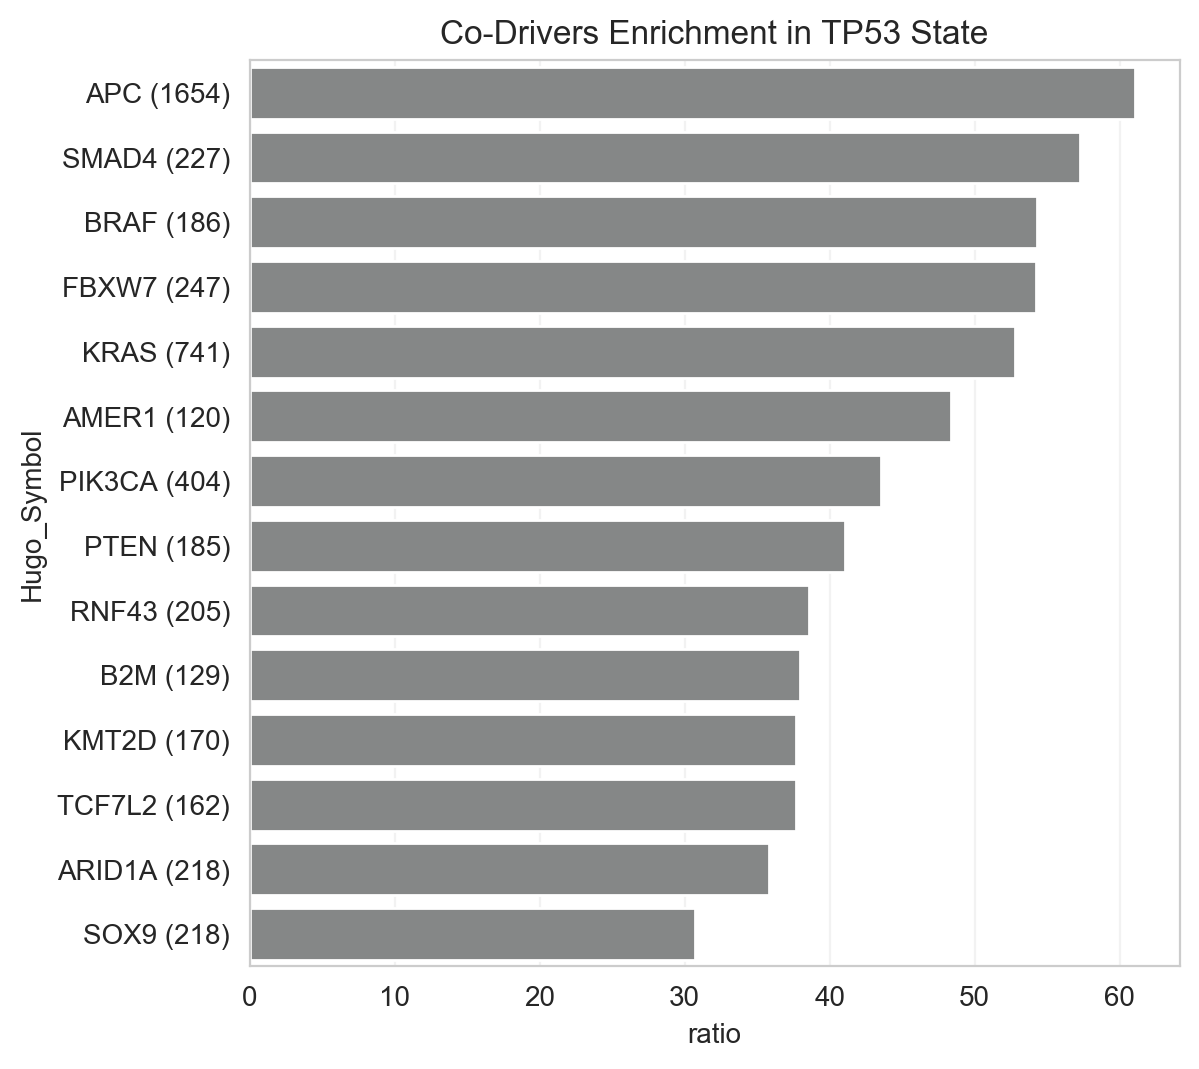

In [99]:
labels = []
for element in co_drivers.index.tolist():
    labels.append(element + ' ('+ str(int(co_drivers.loc[element]['cancer']))+')')

ax = sns.barplot(y=co_drivers.index, x='ratio',data=co_drivers[['ratio']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Co-Drivers Enrichment in TP53 State')

In [17]:
codrivers_cancer

,count
Hugo_Symbol,
APC,1654
KRAS,741
PIK3CA,404
FBXW7,247
SMAD4,227
ARID1A,218
SOX9,218
RNF43,205
BRAF,186


Text(0.5, 1.0, 'Drivers Frequency in Colorectal Cancer')

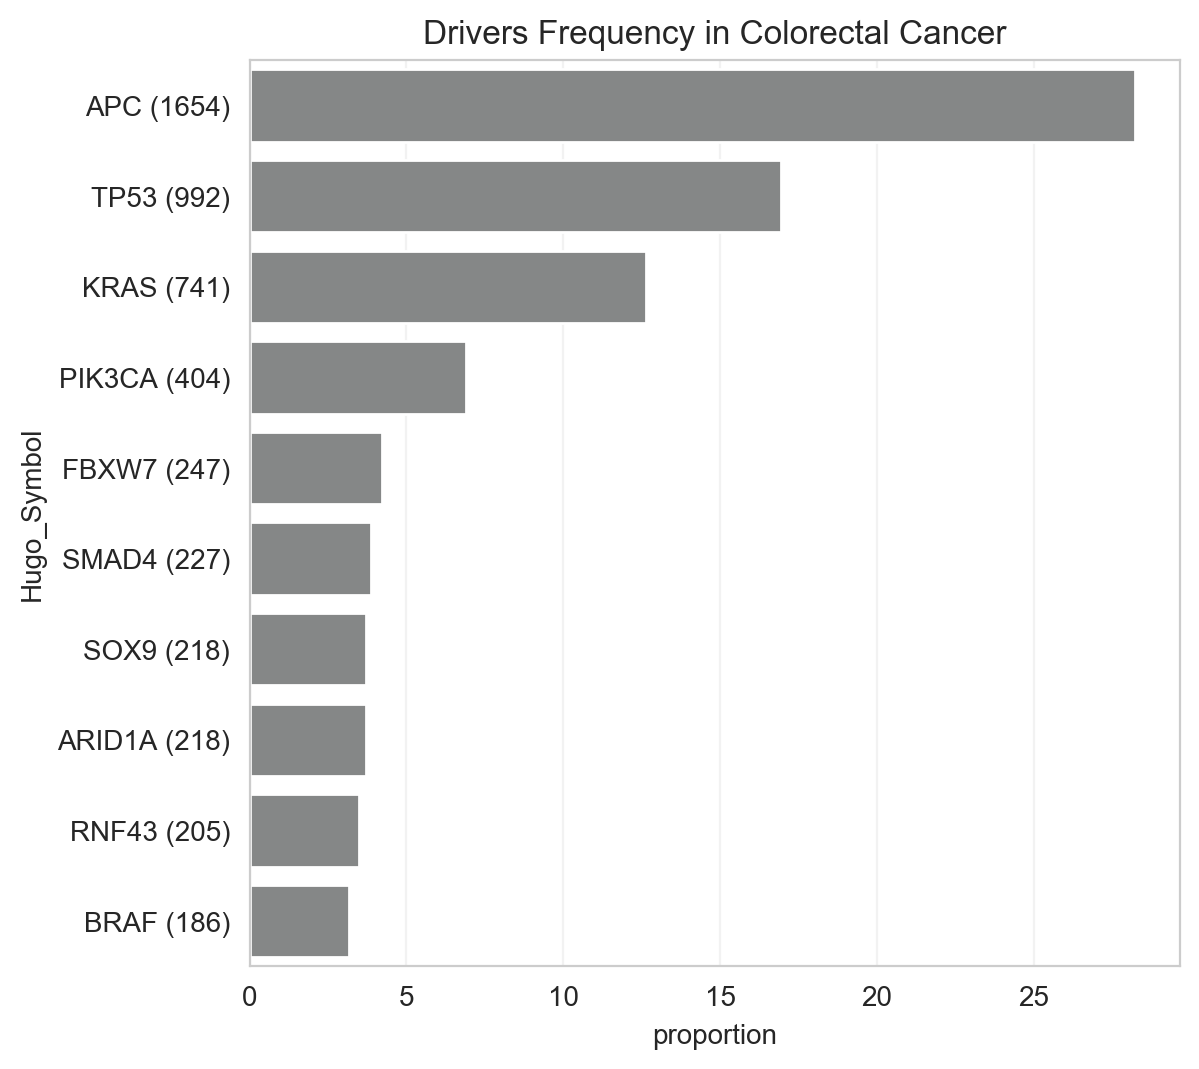

In [97]:
labels = []
codrivers_cancer = get_major_codrivers(master=master_no_wgd_cancer,
                                       maf=maf_cohort_nowgd,
                                       head=15,
                                      tp53=True)

codrivers_cancer['proportion'] = codrivers_cancer.apply(lambda x: 100* round(x['count'] / codrivers_cancer.sum().values[0], 4), axis=1)

for element in codrivers_cancer.head(10).index.tolist():
    labels.append(element + ' ('+ str(int(codrivers_cancer.loc[element]['count']))+')')

ax = sns.barplot(y=codrivers_cancer.head(10).index, x='proportion',data=codrivers_cancer.head(10)[['proportion']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Drivers Frequency in {}'.format(cancer))

### Co-Drivers per subgroup

In [107]:
co_drivers_res = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_res_group',
                                                group_1='tp53_res',
                                                group_2='no_tp53_res')
co_drivers_res

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
APC,281,-15.45,893,33.23
KRAS,150,-8.25,334,12.43
PIK3CA,78,-4.29,126,4.69
SOX9,45,-2.47,47,1.75
PTEN,44,-2.42,34,1.27
FBXW7,44,-2.42,97,3.61
RNF43,43,-2.36,37,1.38
KMT2D,40,-2.20,22,0.82
ARID1A,38,-2.09,41,1.53


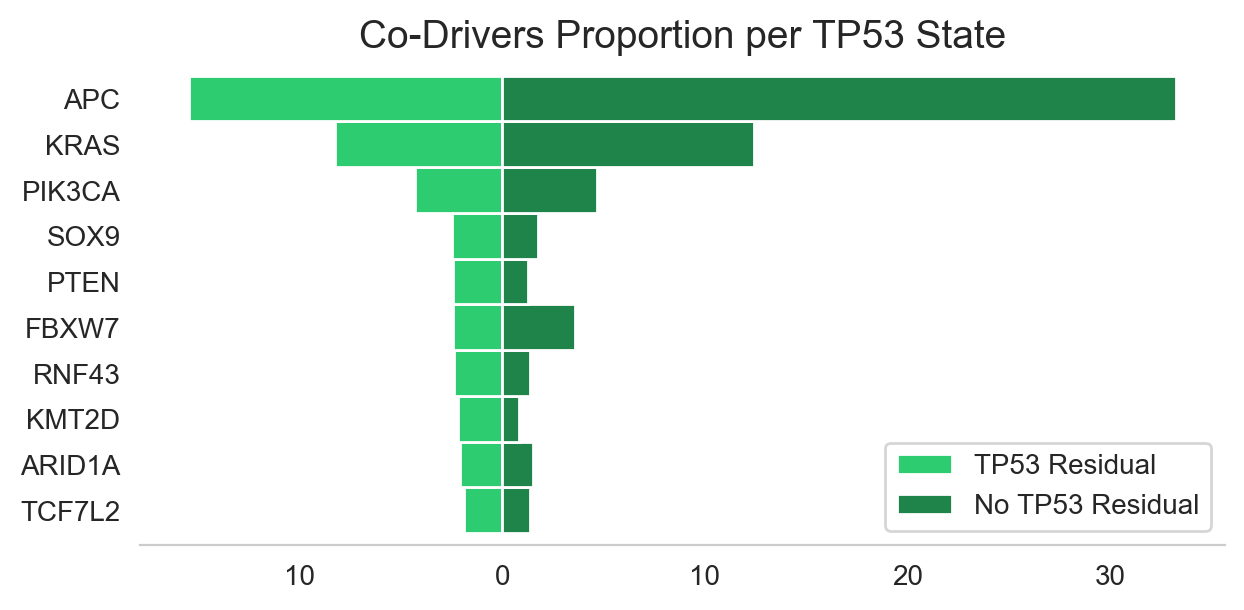

In [110]:
fig=plt.figure(figsize=(7,7))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_res[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = ['#2ECC71','#1E8449'])
ax.legend(['TP53 Residual', 'No TP53 Residual'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [20, 10, 0, 10, 20, 30, 40]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

In [19]:
co_drivers_cnloh_loss = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='>=1_cnLOH',
                                                group_2='>=1_LOSS')
co_drivers_cnloh_loss

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
APC,129,-35.25,708,36.51
KRAS,45,-12.30,268,13.82
PIK3CA,19,-5.19,102,5.26
SMAD4,14,-3.83,98,5.05
FBXW7,13,-3.55,74,3.82
BRAF,11,-3.01,50,2.58
AMER1,6,-1.64,35,1.81
ARID1A,6,-1.64,22,1.13
SOX9,5,-1.37,38,1.96


NameError: name 'subgroup' is not defined

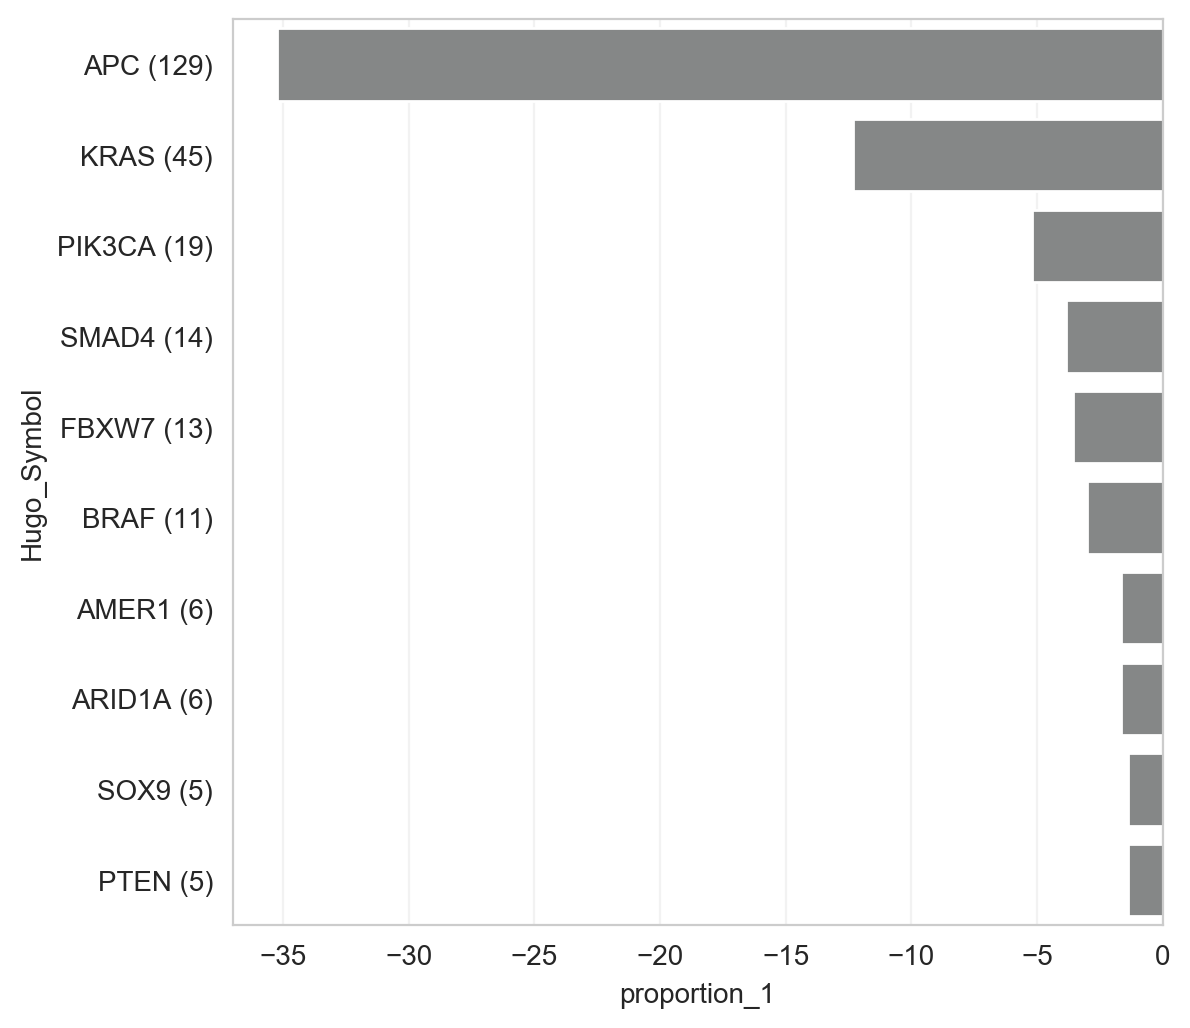

In [20]:
labels = []
for element in co_drivers_cnloh_loss.head(10).index.tolist():
    labels.append(element + ' ('+ str(int(co_drivers_cnloh_loss.loc[element]['count_x']))+')')

ax = sns.barplot(y=co_drivers_cnloh_loss.head(10).index, x='proportion_1',data=co_drivers_cnloh_loss.head(10)[['proportion_1']], color='#7F8C8D', saturation=.2)
ax.set_yticklabels(labels)
ax.set_title('Co-Drivers Frequency in {} - {}'.format(subgroup, cancer))

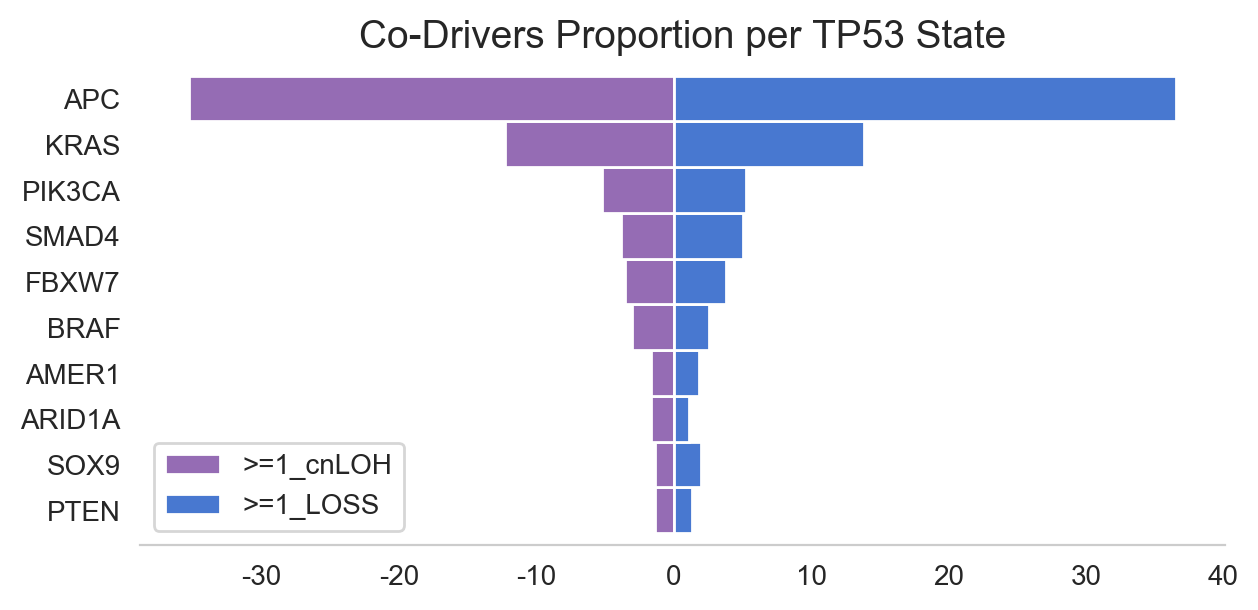

In [30]:
fig=plt.figure(figsize=(7,7))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_cnloh_loss[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[4],mc[0]])
ax.legend(['>=1_cnLOH', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-40, -30, -20, -10, 0, 10, 20, 30, 40, 50]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

Proportion are the same in both groups

In [31]:
co_drivers_losses = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='0_HETLOSS',
                                                group_2='>=1_LOSS')
co_drivers_losses

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
APC,180,-32.09,708,36.51
KRAS,100,-17.83,268,13.82
PIK3CA,33,-5.88,102,5.26
SOX9,26,-4.63,38,1.96
SMAD4,19,-3.39,98,5.05
ATM,18,-3.21,8,0.41
SMAD2,12,-2.14,9,0.46
NRAS,11,-1.96,36,1.86
TCF7L2,11,-1.96,28,1.44


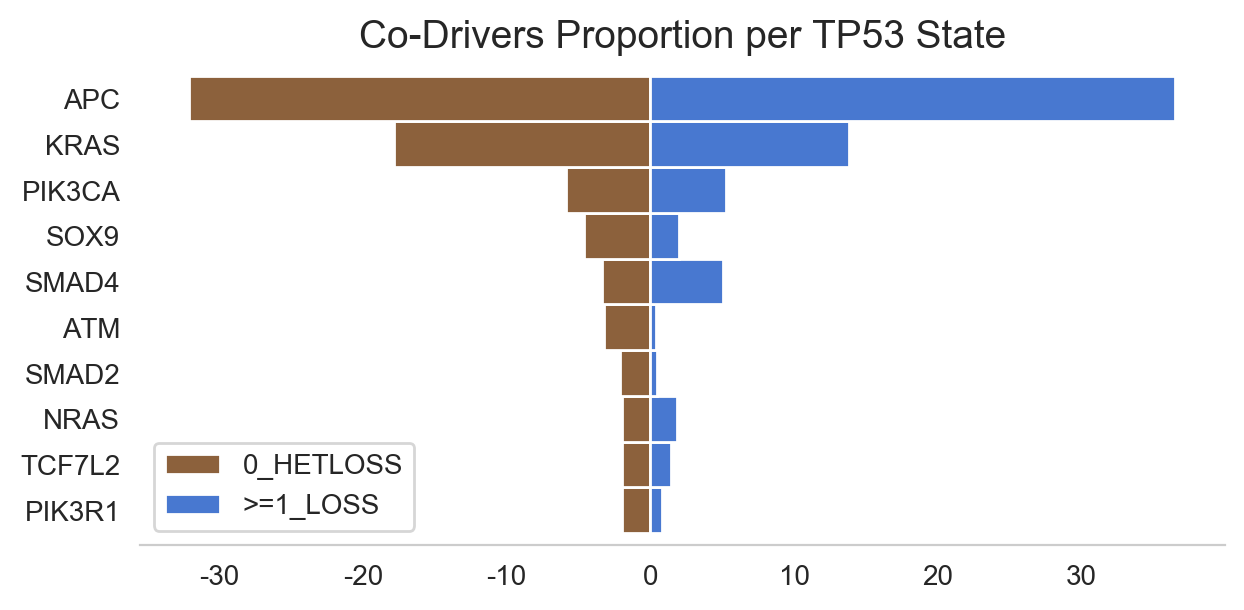

In [36]:
fig=plt.figure(figsize=(7,7))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_losses[['proportion_1', 'proportion_2']].head(10)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[5],mc[0]])
ax.legend(['0_HETLOSS', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-40, -30, -20, -10, 0, 10, 20, 30, 40]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

Same proportions, enrichment in **APC** and **KRAS**

---

In [42]:
co_drivers_mult_cnloh = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='>1muts',
                                                group_2='>=1_cnLOH')
co_drivers_mult_cnloh

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
APC,81,-10.24,129,35.25
KRAS,30,-3.79,45,12.30
KMT2D,27,-3.41,1,0.27
RNF43,20,-2.53,3,0.82
FBXW7,19,-2.40,13,3.55
PIK3CA,18,-2.28,19,5.19
ARID1A,16,-2.02,6,1.64
MSH3,16,-2.02,1,0.27
PTEN,15,-1.90,5,1.37


In [43]:
get_major_codrivers(master=master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>1muts'],
                    maf=maf_cohort_nowgd,
                    head=100)

,count
Hugo_Symbol,
APC,81
KRAS,30
KMT2D,27
RNF43,20
FBXW7,19
PIK3CA,18
B2M,17
ARID1A,16
MSH3,16


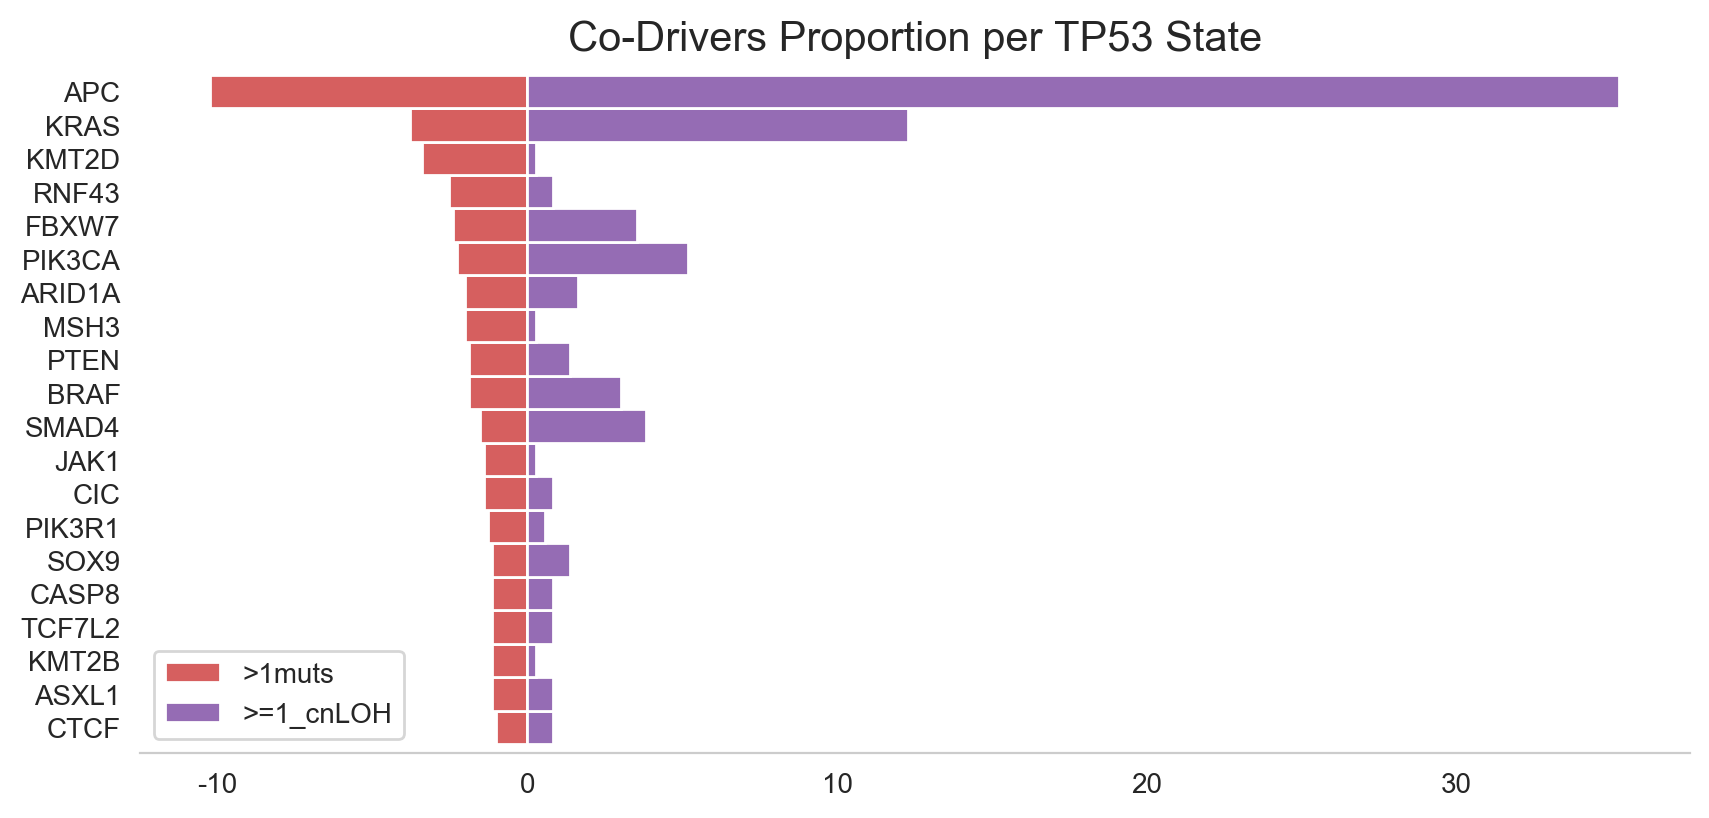

In [51]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_mult_cnloh[['proportion_1', 'proportion_2']].head(20)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[3],mc[4]])
ax.legend(['>1muts', '>=1_cnLOH'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=15)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-20, -10, 0, 10, 20, 30, 40]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

* Same pattern of co-drivers distribution
---

In [55]:
co_drivers_wt_loss = create_co_drivers_table(master=master_no_wgd_cancer, 
                                                group_type='tp53_group',
                                                group_1='1_WILD_TYPE',
                                                group_2='>=1_LOSS')
co_drivers_wt_loss

,count_x,proportion_1,count_y,proportion_2
Hugo_Symbol,,,,
APC,76,-7.52,708,36.51
KRAS,40,-3.96,268,13.82
RNF43,37,-3.66,18,0.93
PIK3CA,34,-3.36,102,5.26
ARID1A,33,-3.26,22,1.13
KMT2D,30,-2.97,6,0.31
PTEN,29,-2.87,26,1.34
FBXW7,27,-2.67,74,3.82
BRAF,24,-2.37,50,2.58


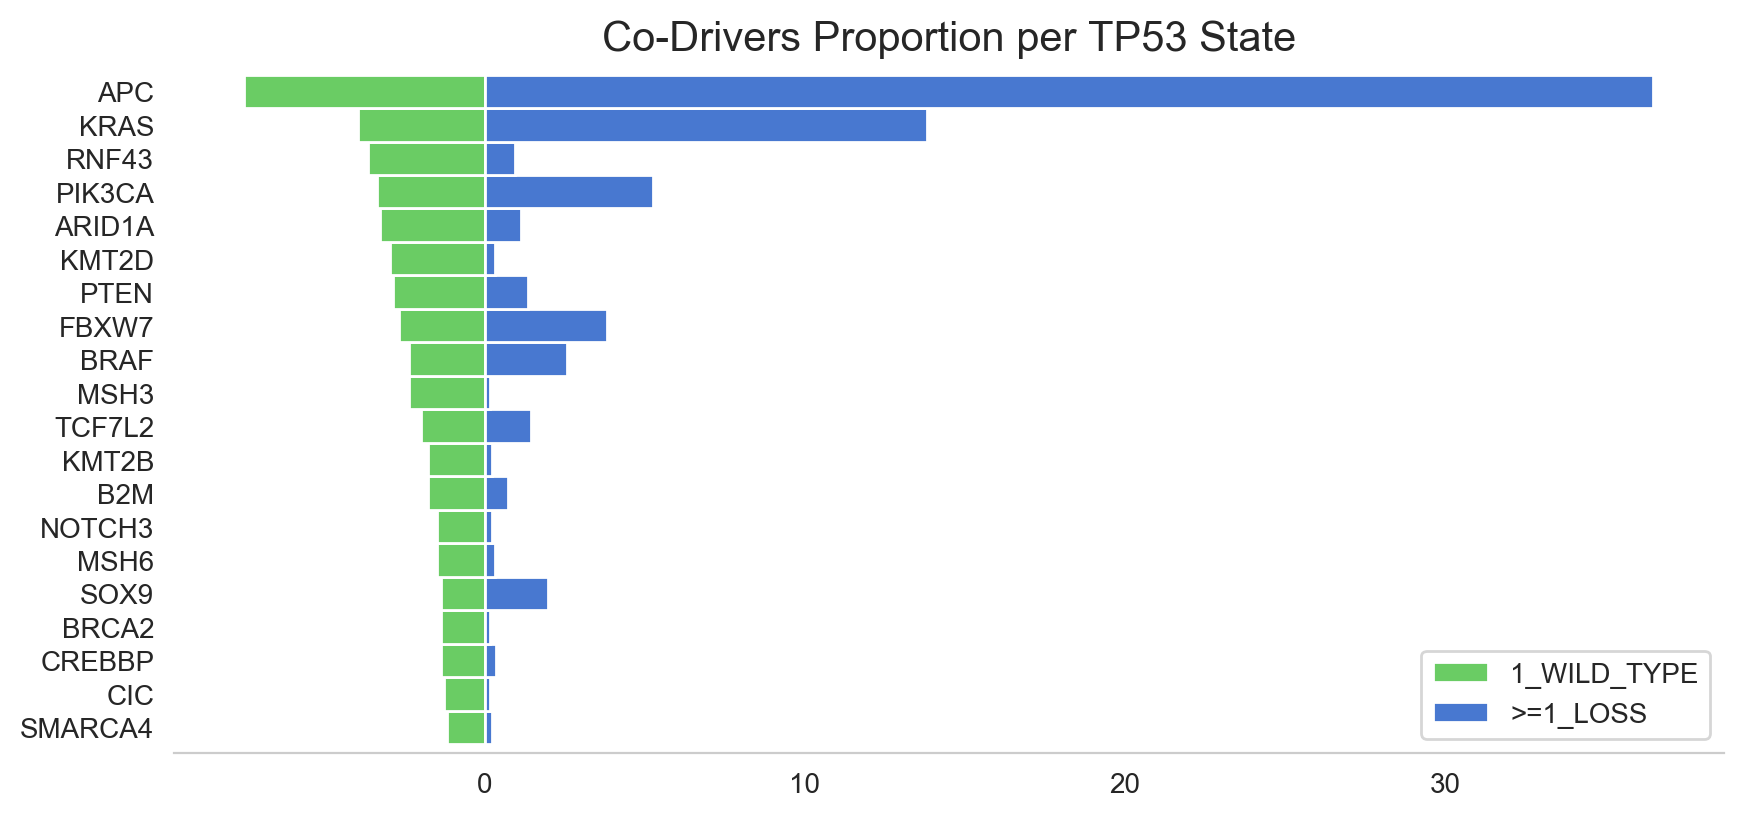

In [60]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_wt_loss[['proportion_1', 'proportion_2']].head(20)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = [mc[2],mc[0]])
ax.legend(['1_WILD_TYPE', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=15)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-10, 0, 10, 20, 30, 40]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

#### Comparison with WGD Cohort (WGD - TP53 - LOH)

In [81]:
def get_major_codrivers(master: pd.DataFrame, maf: pd.DataFrame, head:int = 10):
    samples = master.Tumor_Id.tolist()
    maf_filtered = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['driver'] == True][maf['Hugo_Symbol'] != 'TP53']
    h = pd.DataFrame(maf_filtered[['Hugo_Symbol']].groupby(['Hugo_Symbol']).size())
    h.columns = ['count']
    h = h.sort_values(by='count', ascending=False).head(head)
    
    return(h)

def create_co_drivers_table_wgd(master_1: pd.DataFrame, master_2: pd.DataFrame, group_type:str,  group_1: str):
    master_group_1 = master_1[master_1[group_type] == group_1]
    co_drivers_group_1 = get_major_codrivers(master=master_group_1,
                        maf=maf_cohort_nowgd,
                       head=100)
    co_drivers_group_1['proportion_1'] = co_drivers_group_1.apply(lambda x: 100* round(x['count'] / co_drivers_group_1.sum().values[0], 4), axis=1)
    
    master_group_2 = master_2[master_2['tp53_count'] >=1][master_2['tp53_loh_status'] == True]
    co_drivers_group_2 = get_major_codrivers(master=master_group_2,
                        maf=maf_cohort_wgd,
                       head=100)
    co_drivers_group_2['proportion_2'] = co_drivers_group_2.apply(lambda x: 100* round(x['count'] / co_drivers_group_2.sum().values[0], 4), axis=1)
    
    co_drivers_groups = pd.merge(co_drivers_group_2, co_drivers_group_1, on='Hugo_Symbol')
    co_drivers_groups['proportion_2'] = - co_drivers_groups['proportion_2']
    
    return co_drivers_groups

In [82]:
co_drivers_wgd_loss = create_co_drivers_table_wgd(master_1=master_no_wgd_cancer,
                            master_2=master_wgd_cancer,
                            group_type='tp53_group',
                            group_1='>=1_LOSS')
co_drivers_wgd_loss

,count_x,proportion_2,count_y,proportion_1
Hugo_Symbol,,,,
APC,805,-43.26,708,36.51
KRAS,252,-13.54,268,13.82
PIK3CA,79,-4.25,102,5.26
SMAD4,72,-3.87,98,5.05
FBXW7,67,-3.60,74,3.82
TCF7L2,56,-3.01,28,1.44
BRAF,38,-2.04,50,2.58
SOX9,37,-1.99,38,1.96
AMER1,26,-1.40,35,1.81


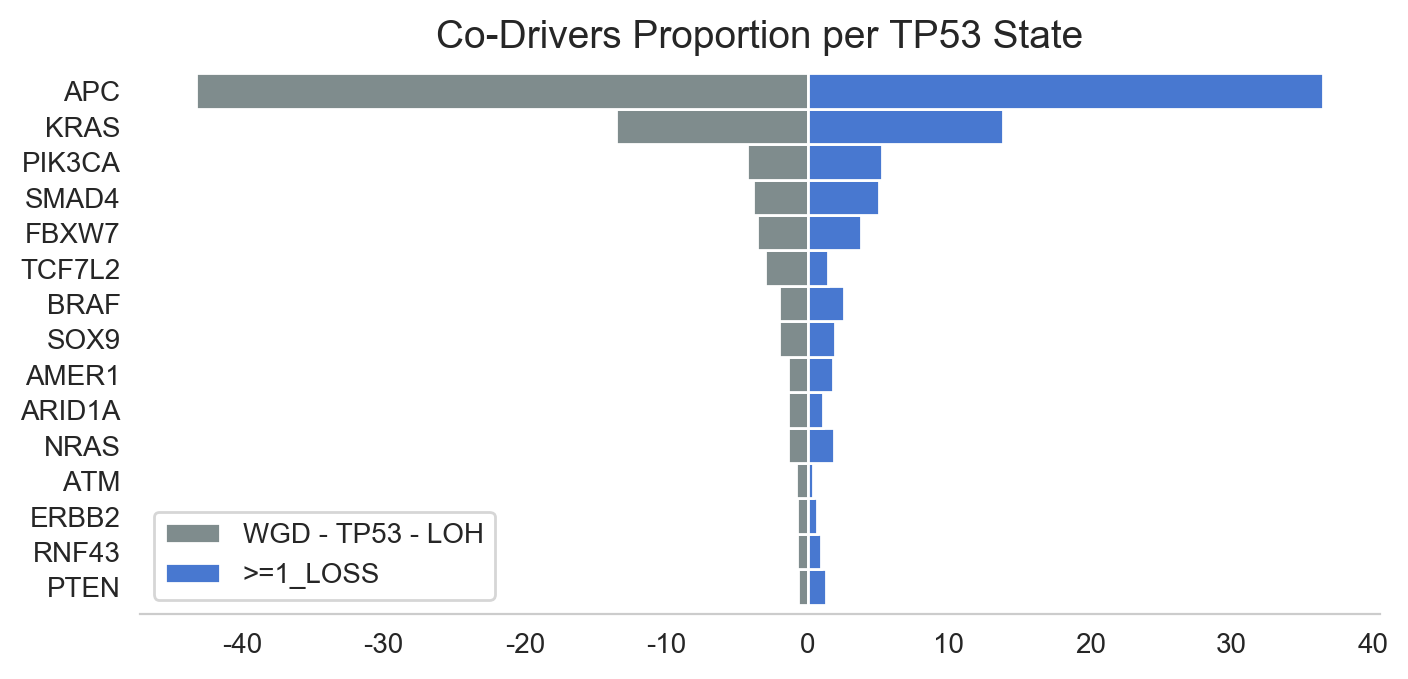

In [85]:
fig=plt.figure(figsize=(8,8))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

co_drivers_wgd_loss[['proportion_2', 'proportion_1']].head(15)[::-1].plot.barh(stacked=True, ax=ax, width=1, color = ['#7F8C8D',mc[0]])
ax.legend(['WGD - TP53 - LOH', '>=1_LOSS'], fontsize=10)
ax.set_title('Co-Drivers Proportion per TP53 State', fontsize=14)

plt.yticks(fontsize=10)
ax.set_ylabel('')
a=ax.get_xticks().tolist()
a = [-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50]
ax.set_xticklabels(a, fontsize=10)
plt.grid(b=None)

plt.show()

### Genome Instability Associated

In [61]:
def get_master_codrivers(master: pd.DataFrame, maf: pd.DataFrame, symbol: str):
    samples = master.Tumor_Id.tolist()
    samples_final = maf[maf.Tumor_Sample_Barcode.isin(samples)][maf['Hugo_Symbol'] == symbol].Tumor_Sample_Barcode.tolist()

    master_filtered = master[master.Tumor_Id.isin(samples_final)]
    
    return master_filtered

#### >=1_cnLOH

In [73]:
master_no_wgd_cancer_cnloh = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>=1_cnLOH']
master_APC = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='APC')

master_KRAS = get_master_codrivers(master=master_no_wgd_cancer_cnloh,
                                   maf=maf_cohort_nowgd,
                                   symbol='KRAS')

master_no_wgd_cancer_cnloh['data'] = '>=1_cnLOH'
master_APC['data'] = 'APC'
master_KRAS['data'] = 'KRAS'
master_PIK3CA['data'] = 'PIK3CA'

masters = [master_no_wgd_cancer_cnloh, master_APC, master_KRAS, master_PIK3CA]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

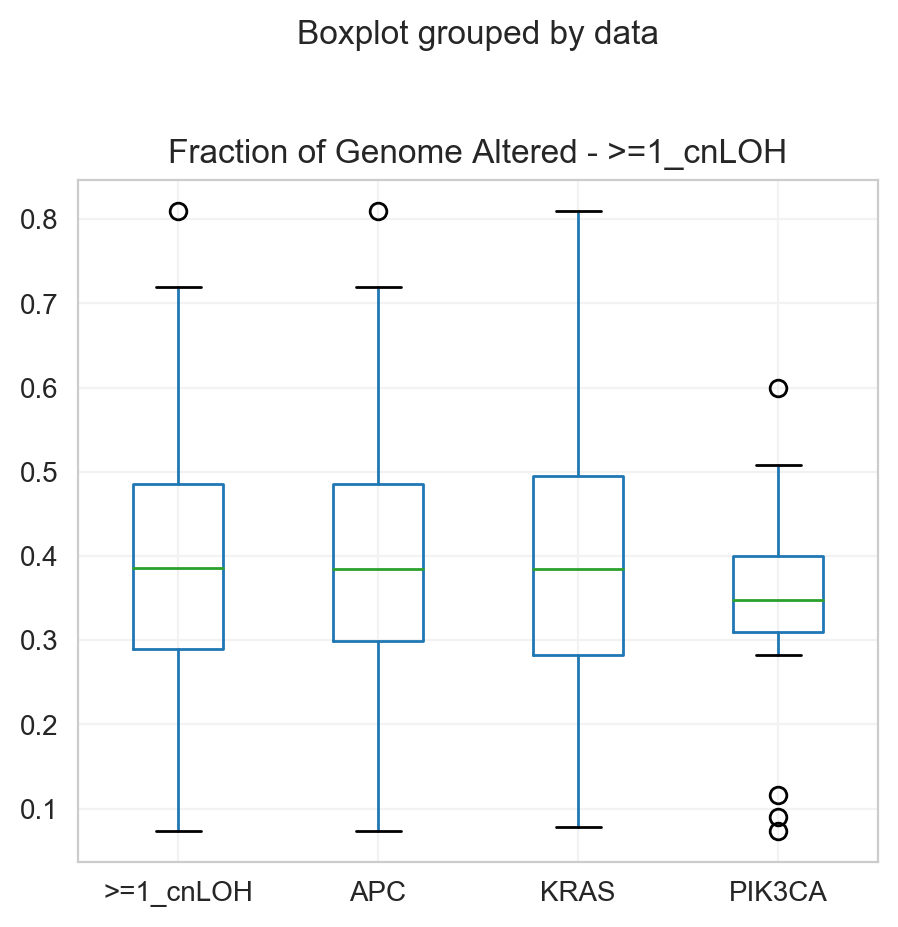

In [74]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >=1_cnLOH')
ax.set_xlabel('')

#### >=1_LOSS

In [78]:
master_no_wgd_cancer_loss = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>=1_LOSS']
master_APC = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='APC')

master_KRAS = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='KRAS')

master_PIK3CA = get_master_codrivers(master=master_no_wgd_cancer_loss,
                                   maf=maf_cohort_nowgd,
                                   symbol='PIK3CA')

master_no_wgd_cancer_loss['data'] = '>=1_loss'
master_APC['data'] = 'APC'
master_KRAS['data'] = 'KRAS'
master_PIK3CA['data'] = 'PIK3CA'

masters = [master_no_wgd_cancer_loss, master_APC, master_KRAS, master_PIK3CA]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

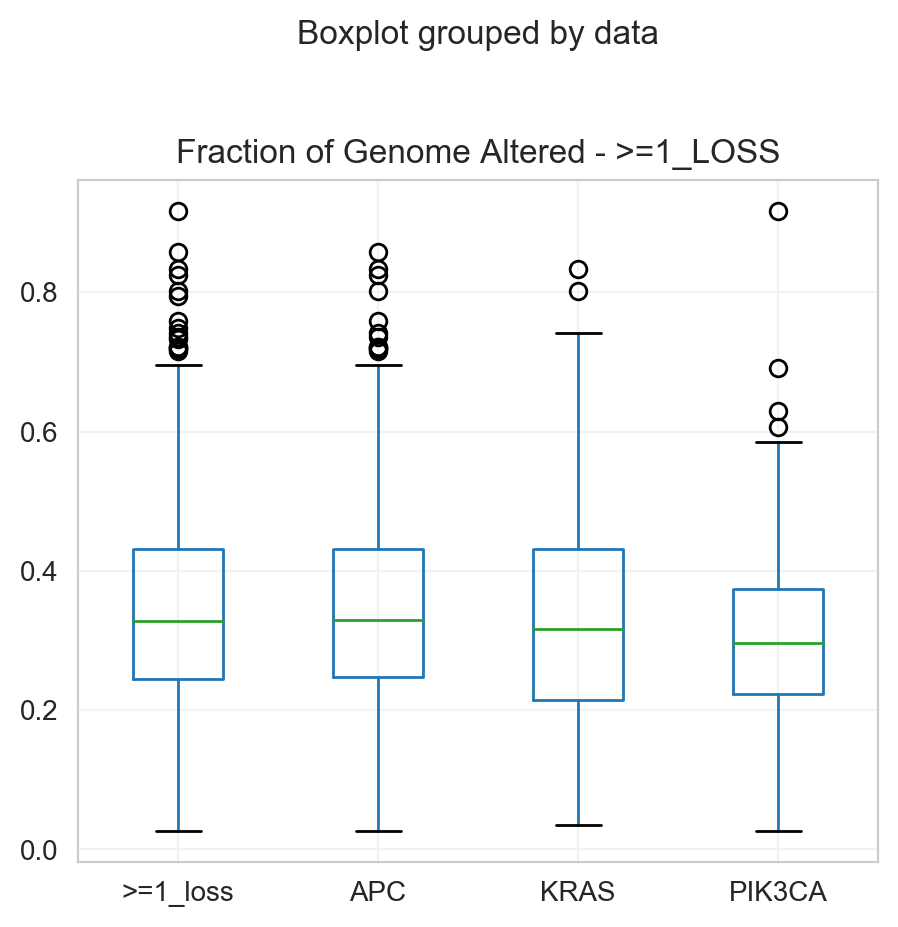

In [79]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >=1_LOSS')
ax.set_xlabel('')

#### >1muts

In [77]:
master_no_wgd_cancer_muts = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '>1muts']
master_APC = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='APC')

master_KRAS = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='KRAS')

master_KMT2D = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='KMT2D')

master_RNF43 = get_master_codrivers(master=master_no_wgd_cancer_muts,
                                   maf=maf_cohort_nowgd,
                                   symbol='RNF43')

master_no_wgd_cancer_muts['data'] = '>1muts'
master_APC['data'] = 'APC'
master_KRAS['data'] = 'KRAS'
master_KMT2D['data'] = 'KMT2D'
master_RNF43['data'] = 'RNF43'

masters = [master_no_wgd_cancer_muts, master_APC, master_KRAS, master_KMT2D, master_RNF43]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

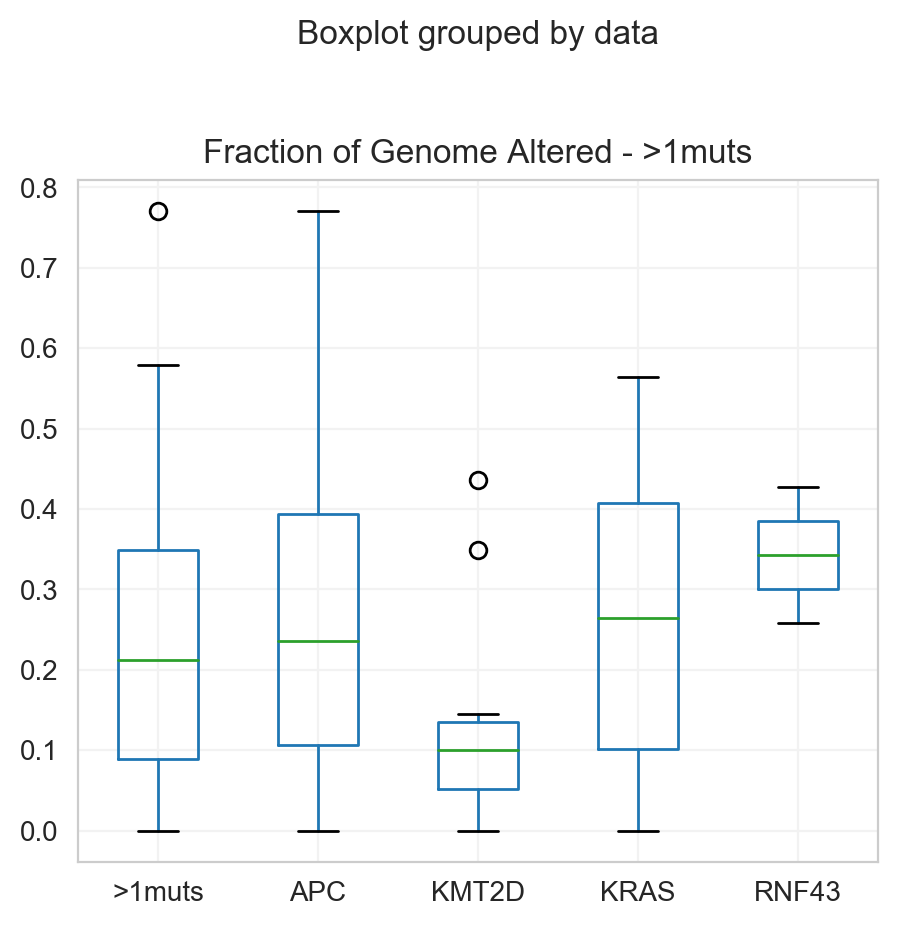

In [76]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - >1muts')
ax.set_xlabel('')

#### 1_WILD_TYPE

In [92]:
master_no_wgd_cancer_wt = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == '1_WILD_TYPE']
master_APC = get_master_codrivers(master=master_no_wgd_cancer_wt,
                                   maf=maf_cohort_nowgd,
                                   symbol='APC')

master_KRAS = get_master_codrivers(master=master_no_wgd_cancer_wt,
                                   maf=maf_cohort_nowgd,
                                   symbol='KRAS')

master_RNF43 = get_master_codrivers(master=master_no_wgd_cancer_wt,
                                   maf=maf_cohort_nowgd,
                                   symbol='RNF43')

master_no_wgd_cancer_wt['data'] = '1_WT'
master_APC['data'] = 'APC'
master_KRAS['data'] = 'KRAS'
master_RNF43['data'] = 'RNF43'

masters = [master_no_wgd_cancer_wt, master_APC, master_KRAS, master_RNF43]
allMasters = pd.concat(masters)

Text(0.5, 0, '')

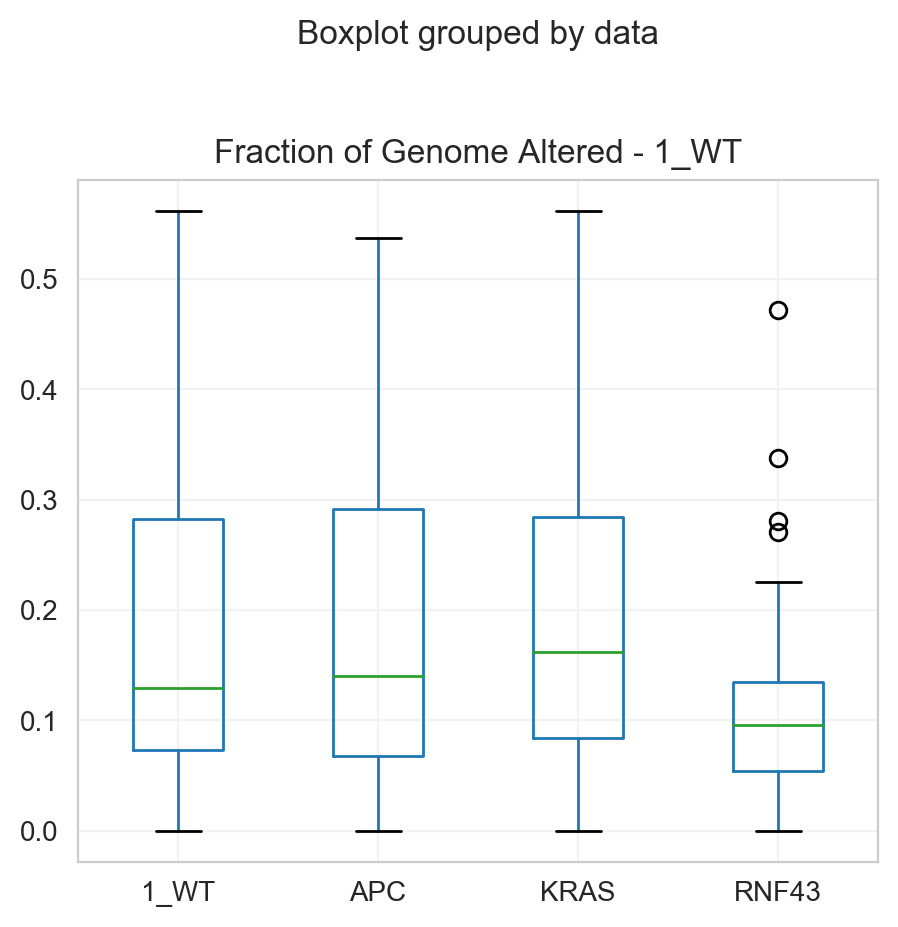

In [94]:
fig=plt.figure(figsize=(5,10))
ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
allMasters[['frac_genome_altered', 'data']].boxplot(by="data", ax=ax)
ax.set_title('Fraction of Genome Altered - 1_WT')
ax.set_xlabel('')

## CCF / VAF Analysis
Same here we take only samples with exactly 1 tp53 mutation (*master_hotspot*).

We have to define groups for CCF to see if there are differences between those groups. To have an idea of the CCF distribution we show here the distribution coming from the *cancer_panel*.

<img src="colorectal_ccf.png" width=1000 length=1000>

We see that our tp53_ccf distribution is very high for all subgroups. *>=1_LOSS* is the biggest subgroup - by far - and has a very high CCF median.

It will be hard to cut the cohort based on the CCF. Let's try and see the size of the subcohorts:

In [70]:
master_ccf = master_no_wgd_cancer[(master_no_wgd_cancer['tp53_count'] == 1) | (master_no_wgd_cancer['tp53_group'] == '0_HETLOSS')]

In [71]:
thr_ccf_1 = 0.8 ; thr_ccf_2 = 0.9

def ccf_subgroup(x):
    if x.tp53_ccf_1 <= thr_ccf_1: return 'low'
    elif x.tp53_ccf_1 <= thr_ccf_2: return 'medium'
    elif x.tp53_ccf_1 > thr_ccf_2: return 'high'

master_ccf['ccf_group'] = master_ccf.apply(ccf_subgroup, axis=1)
get_groupby(master_ccf, 'ccf_group', 'count')

,count
ccf_group,
high,624
low,90
medium,98


In [72]:
thr_vaf_1 = 0.3 ; thr_vaf_2 = 0.4

def vaf_subgroup(x):
    if x.tp53_vaf_1 <= thr_vaf_1: return 'low'
    elif x.tp53_vaf_1 <= thr_vaf_2: return 'medium'
    elif x.tp53_vaf_1 > thr_vaf_2: return 'high'

master_ccf['vaf_group'] = master_ccf.apply(vaf_subgroup, axis=1)       
get_groupby(master_ccf, 'vaf_group', 'count')

,count
vaf_group,
high,249
low,409
medium,157


### VAF Analysis

#### No VAF Cut

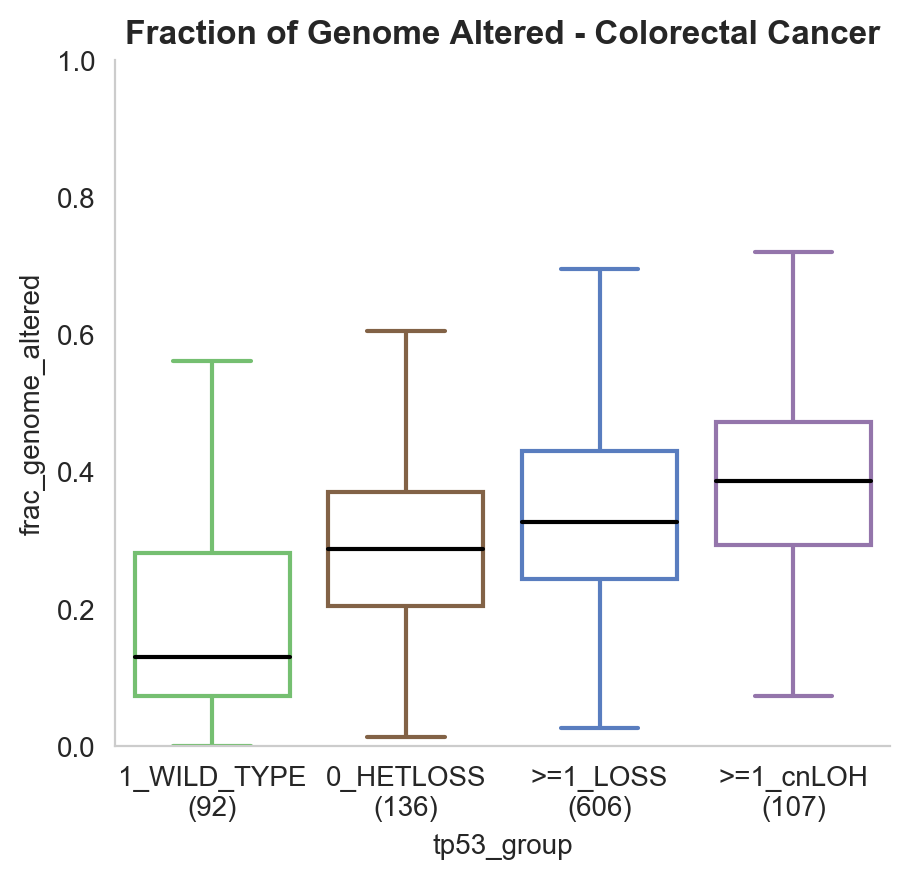

,0,1,2
0,,size,frac_genome_altered
1,0_HETLOSS,136,0.2875
2,1_WILD_TYPE,92,0.1295
3,,Statistics,p-value
4,,6.06375,1.32985e-09


In [76]:
fig, ax = boxplot_sampletype(df=master_ccf,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_ccf,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['0_HETLOSS', '1_WILD_TYPE'])

#### Low VAF

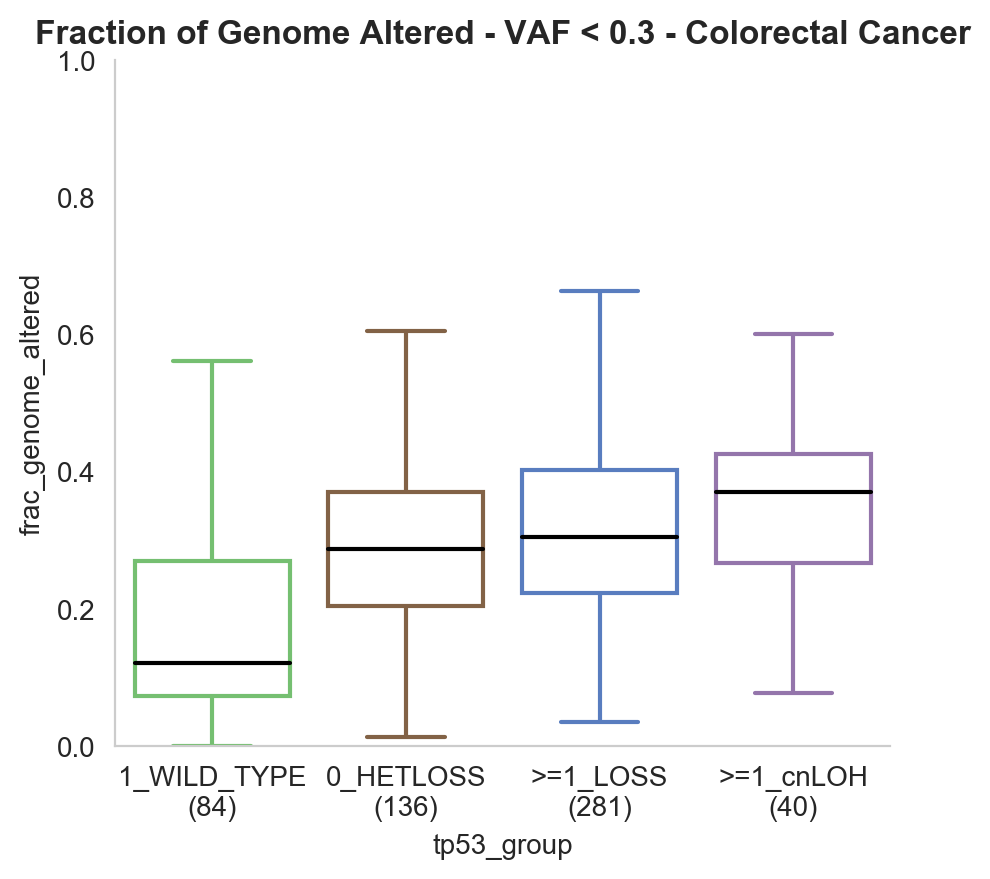

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,84,0.1215
2,>=1_LOSS,281,0.305
3,,Statistics,p-value
4,,-8.15338,3.53883e-16


In [96]:
master_low = master_ccf[(master_ccf['vaf_group'] == 'low') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_low,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - VAF < {} - {}'.format(thr_vaf_1,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_low,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '>=1_LOSS'])

#### Medium VAF

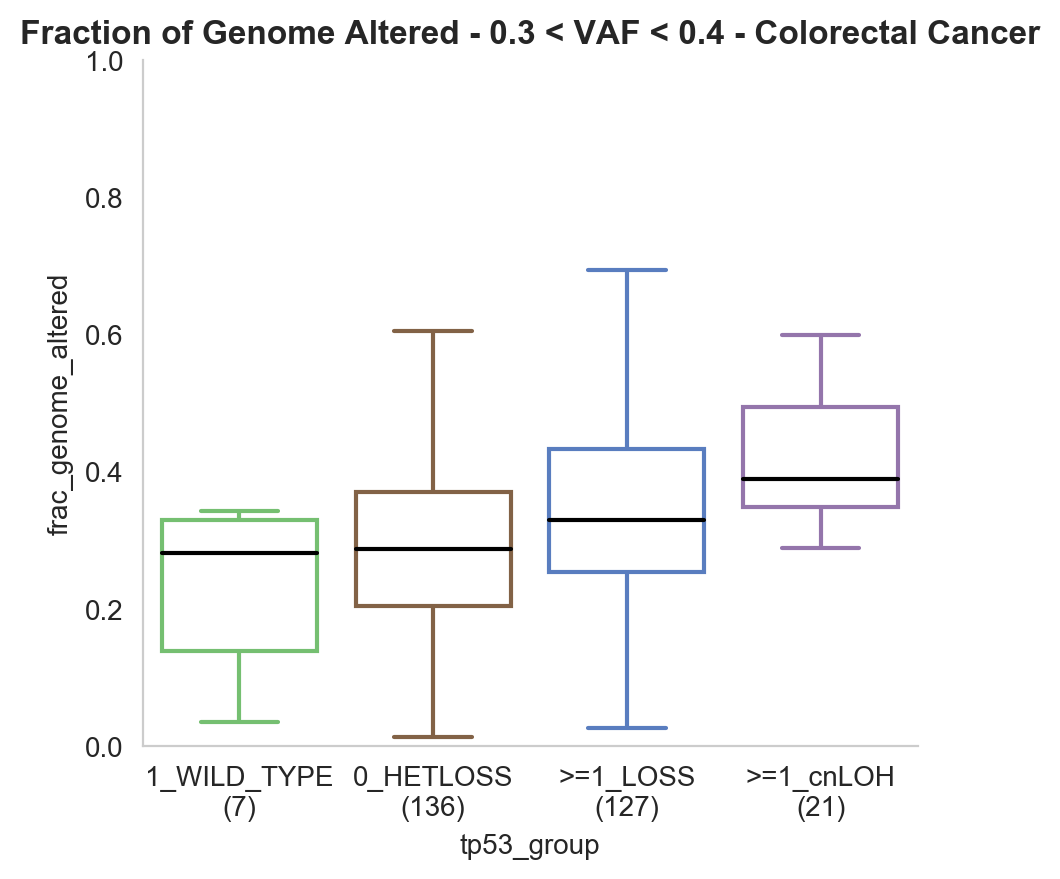

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,7,0.281
2,0_HETLOSS,136,0.2875
3,,Statistics,p-value
4,,-1.02448,0.305607


In [98]:
master_med = master_ccf[(master_ccf['vaf_group'] == 'medium') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_med,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {} < VAF < {} - {}'.format(thr_vaf_1,thr_vaf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_med,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### High VAF

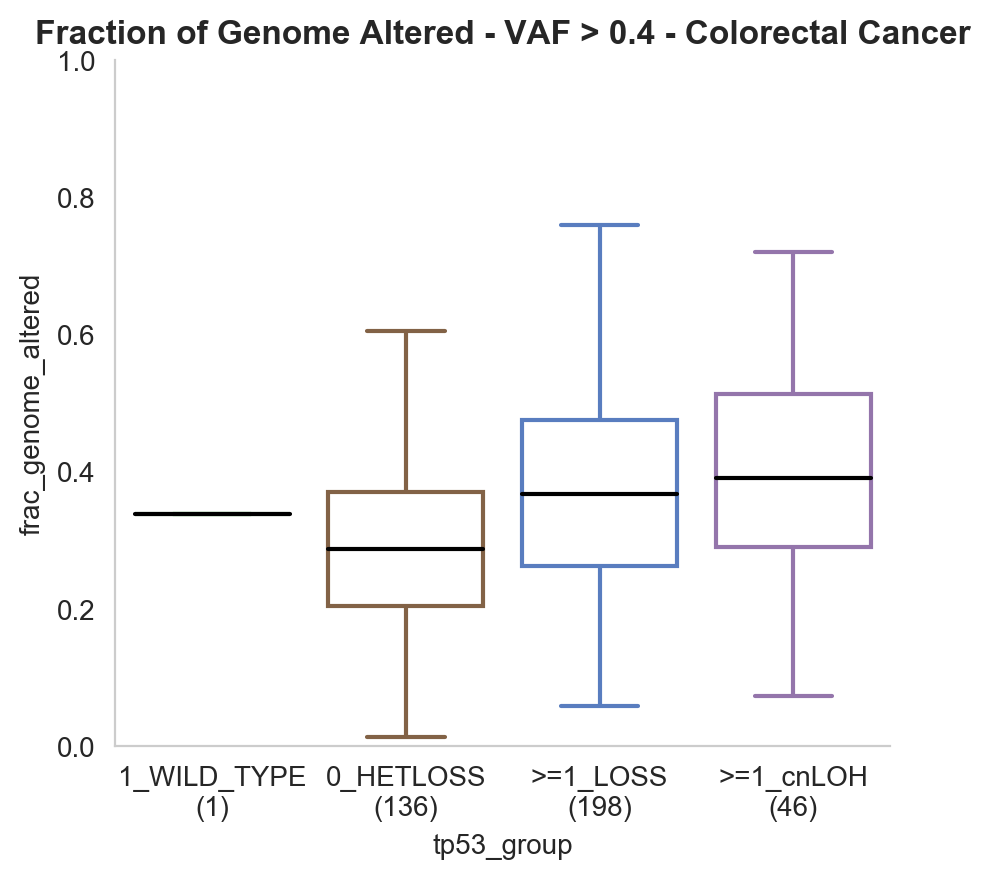

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,1,0.338
2,0_HETLOSS,136,0.2875
3,,Statistics,p-value
4,,0.543651,0.586682


In [99]:
master_high = master_ccf[(master_ccf['vaf_group'] == 'high') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_high,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - VAF > {} - {}'.format(thr_vaf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_high,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

### CCF Analysis

#### No CCF Cut

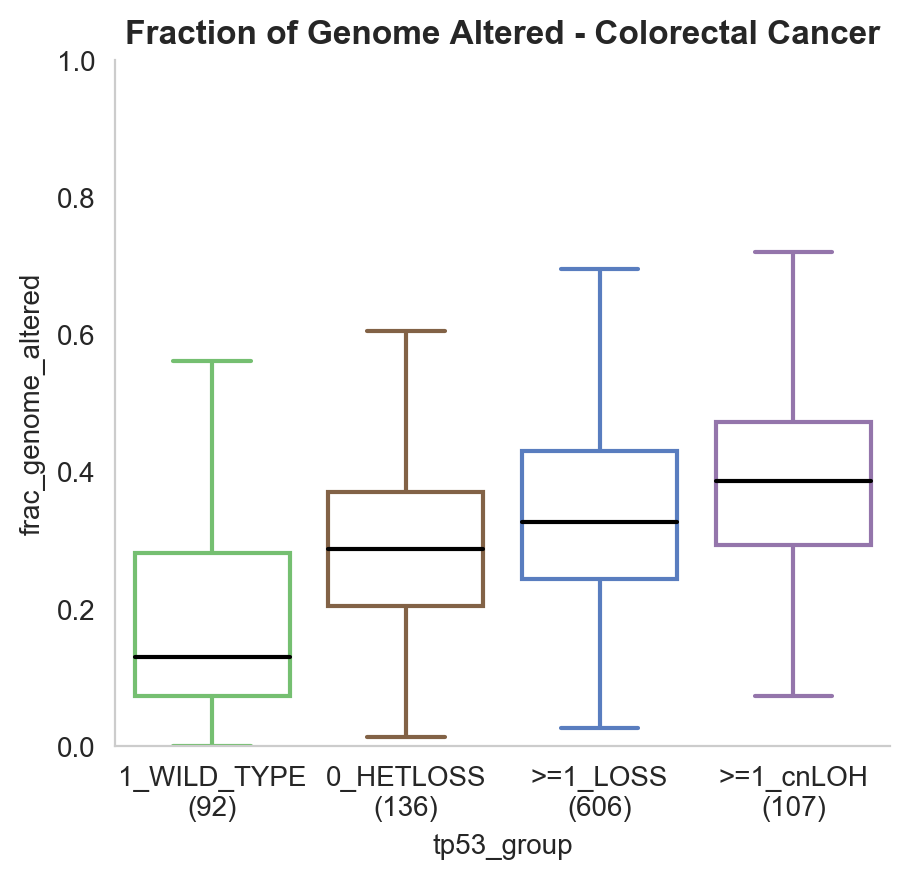

,0,1,2
0,,size,frac_genome_altered
1,0_HETLOSS,136,0.2875
2,1_WILD_TYPE,92,0.1295
3,,Statistics,p-value
4,,6.06375,1.32985e-09


In [80]:
fig, ax = boxplot_sampletype(df=master_ccf,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_ccf,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['0_HETLOSS', '1_WILD_TYPE'])

#### Low CCF

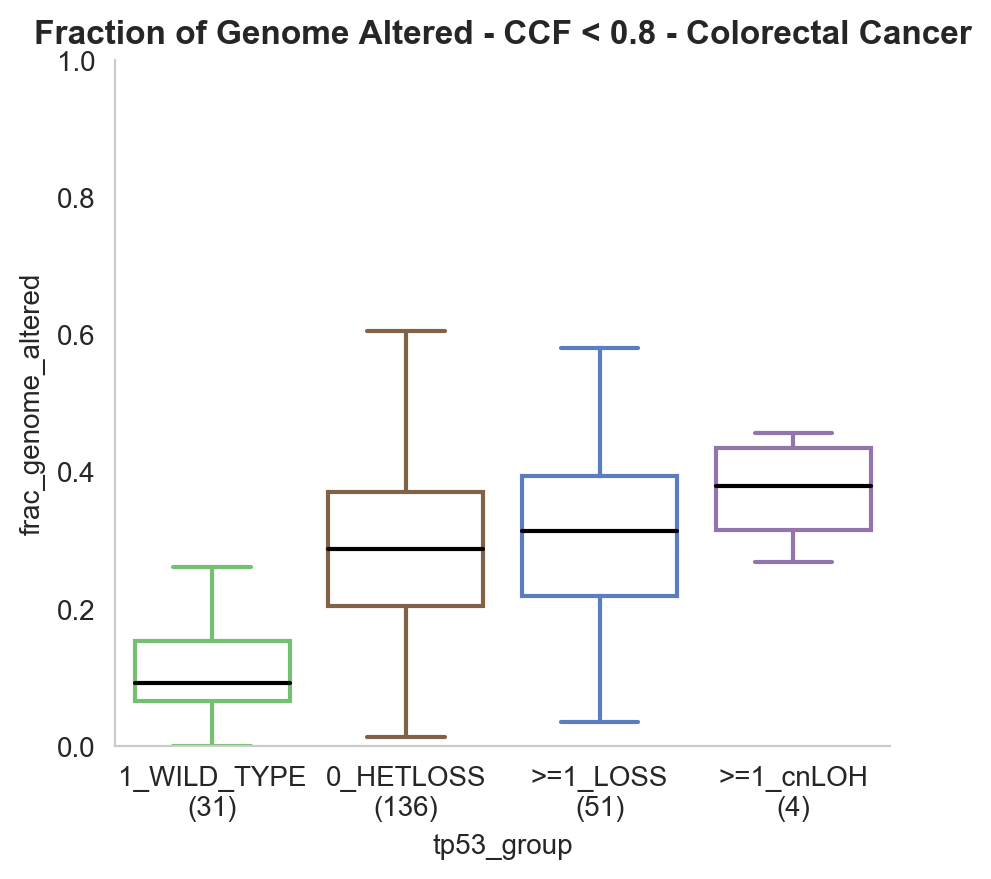

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,31,0.092
2,0_HETLOSS,136,0.2875
3,,Statistics,p-value
4,,-6.28734,3.22953e-10


In [84]:
master_low = master_ccf[(master_ccf['ccf_group'] == 'low') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_low,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE','0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - CCF < {} - {}'.format(thr_ccf_1,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_low,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### Medium CCF

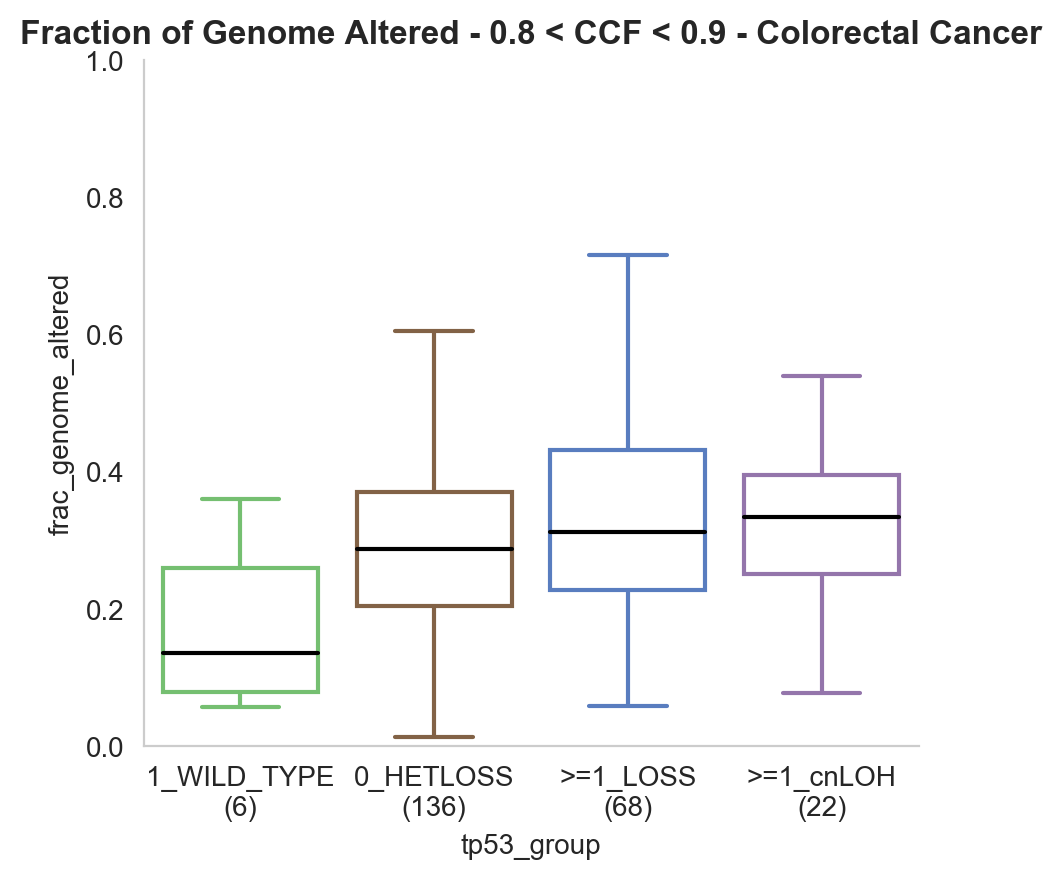

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,6,0.136
2,0_HETLOSS,136,0.2875
3,,Statistics,p-value
4,,-1.98762,0.0468536


In [89]:
master_med = master_ccf[(master_ccf['ccf_group'] == 'medium') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_med,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - {} < CCF < {} - {}'.format(thr_ccf_1,thr_ccf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_med,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

#### High CCF

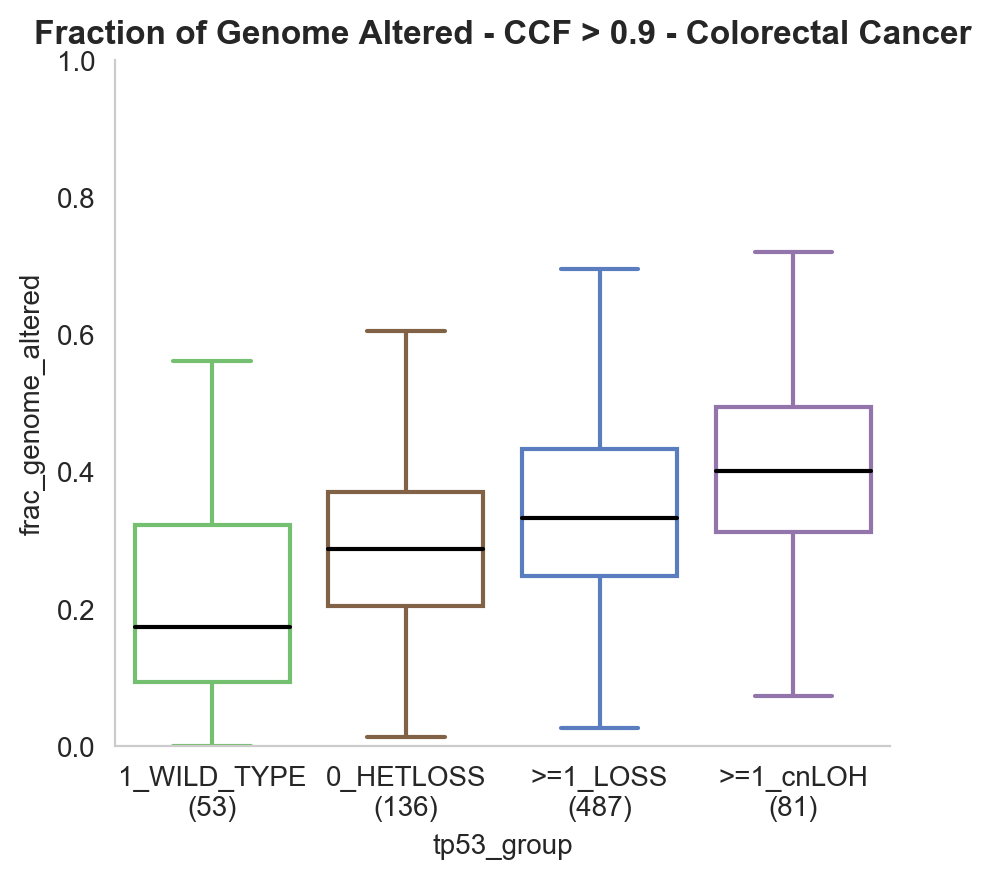

,0,1,2
0,,size,frac_genome_altered
1,1_WILD_TYPE,53,0.174
2,0_HETLOSS,136,0.2875
3,,Statistics,p-value
4,,-3.67792,0.000235139


In [91]:
master_high = master_ccf[(master_ccf['ccf_group'] == 'high') | (master_ccf['tp53_group'] == '0_HETLOSS')]

fig, ax = boxplot_sampletype(df=master_high,
                  group='tp53_group',
                  palette=palette,
                  order=['1_WILD_TYPE', '0_HETLOSS', '>=1_LOSS', '>=1_cnLOH'],
                  metrics='frac_genome_altered',
                  figsize=(5,10),
                  title='Fraction of Genome Altered - CCF > {} - {}'.format(thr_ccf_2,cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_high,
               group='tp53_group',
               metrics='frac_genome_altered',
               group_list=['1_WILD_TYPE', '0_HETLOSS'])

### Splitting on the different level of CCF / VAF

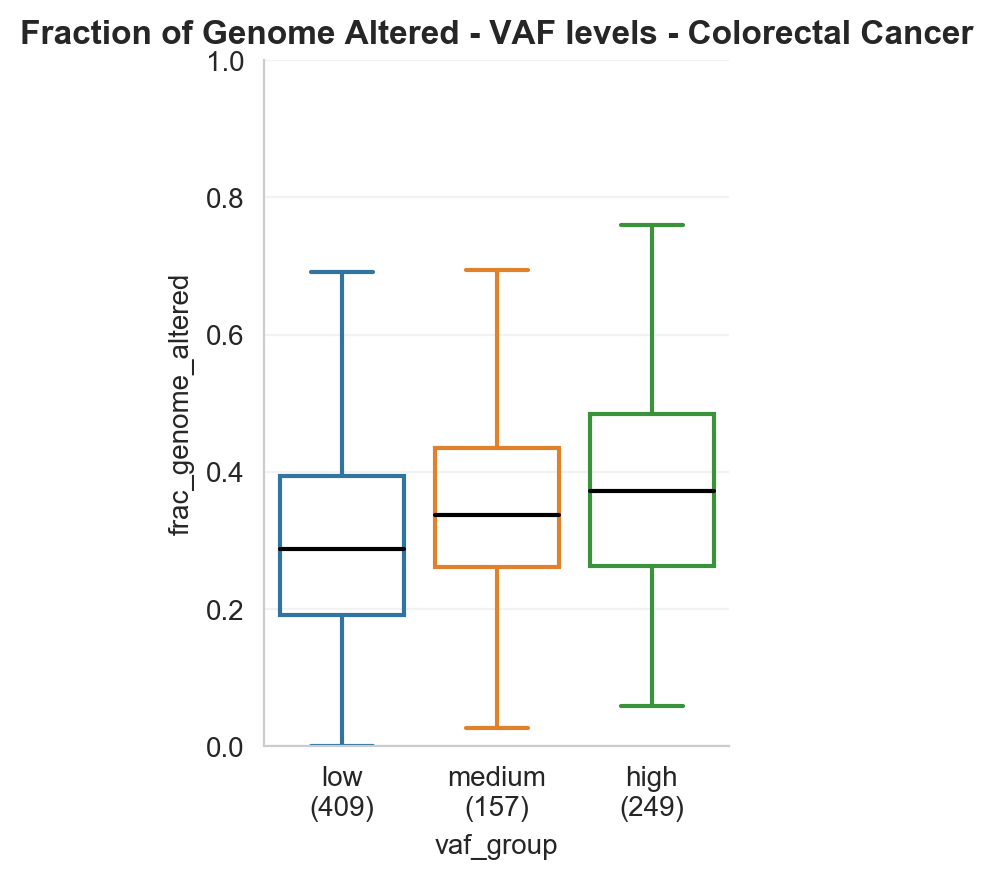

,0,1,2
0,,size,frac_genome_altered
1,low,409,0.288
2,medium,157,0.337
3,,Statistics,p-value
4,,-4.14385,3.41517e-05


In [96]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='vaf_group',
                  palette={'low': tab10[0] , 'medium': tab10[1], 'high':tab10[2]},
                  order=['low', 'medium', 'high'],
                  metrics='frac_genome_altered',
                  figsize=(3,10),
                  title='Fraction of Genome Altered - VAF levels - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_hotspot,
               group='vaf_group',
               metrics='frac_genome_altered',
               group_list=['low', 'medium'])

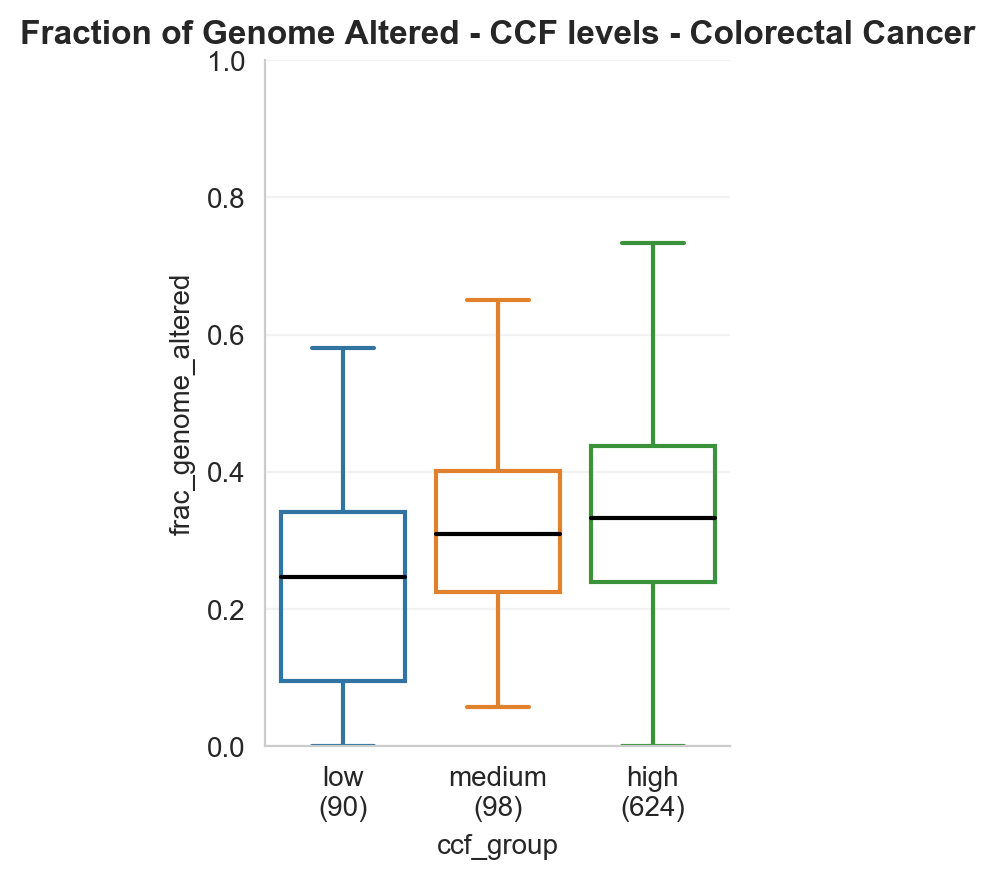

,0,1,2
0,,size,frac_genome_altered
1,low,90,0.2465
2,medium,98,0.31
3,,Statistics,p-value
4,,-3.60197,0.000315819


In [121]:
fig, ax = boxplot_sampletype(df=master_hotspot,
                  group='ccf_group',
                  palette={'low': tab10[0] , 'medium': tab10[1], 'high':tab10[2]},
                  order=['low', 'medium', 'high'],
                  metrics='frac_genome_altered',
                  figsize=(3,10),
                  title='Fraction of Genome Altered - CCF levels - {}'.format(cancer),
                  xlim=[0,1])
plt.show()

get_statistics(df=master_hotspot,
               group='ccf_group',
               metrics='frac_genome_altered',
               group_list=['low', 'medium'])

## Clinical Correlates

### Age

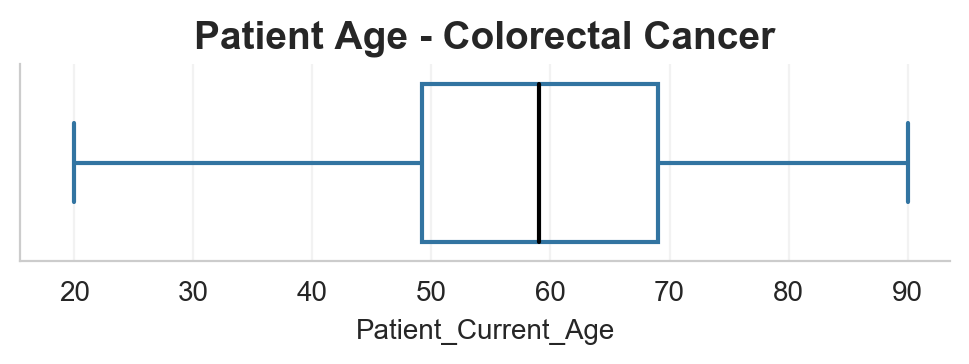

In [120]:
#fig=plt.figure(figsize=(10,3))
ax = plt.subplot2grid(shape=(4,1), loc=(0,0), colspan=1)

sns.boxplot(x='Patient_Current_Age',data=master_no_wgd_cancer, ax=ax).set_title('Patient Age - {}'.format(cancer), weight='bold', fontsize=14)


style(ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### TP53 Residual Groups

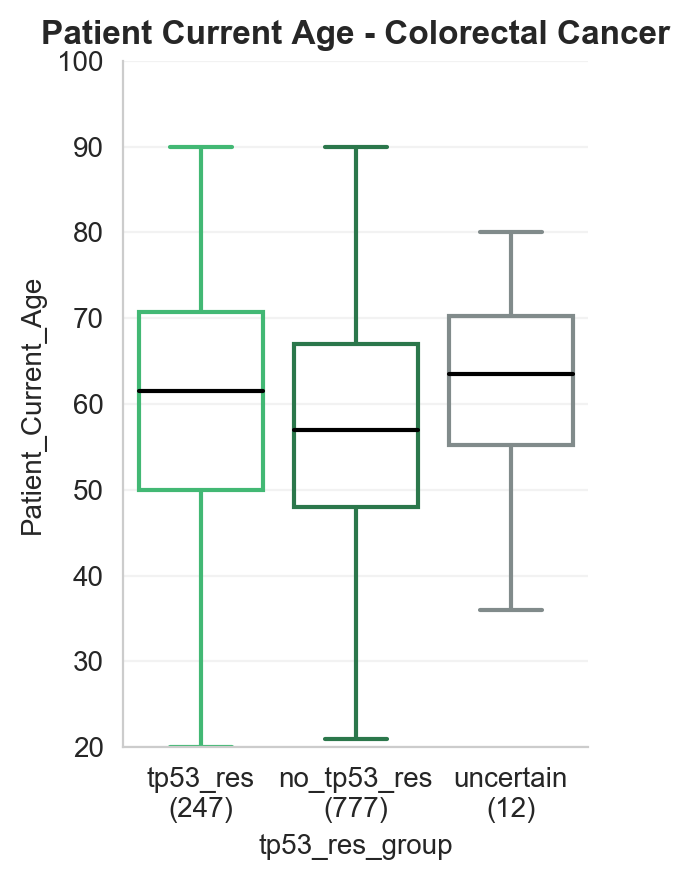

,0,1,2
0,,size,Patient_Current_Age
1,tp53_res,247,61.5
2,no_tp53_res,777,57
3,,Statistics,p-value
4,,2.55386,0.0106536


In [55]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_res_group',
                  palette=palette_res,
                  order=res_group_list,
                  metrics='Patient_Current_Age',
                  figsize=(3,10),
                  title='Patient Current Age - {}'.format(cancer),
                  xlim=[20,100])
plt.show()

get_statistics(df=master_no_wgd_cancer,
               group='tp53_res_group',
               metrics='Patient_Current_Age',
               group_list=['tp53_res', 'no_tp53_res'])

#### TP53 Subgroups

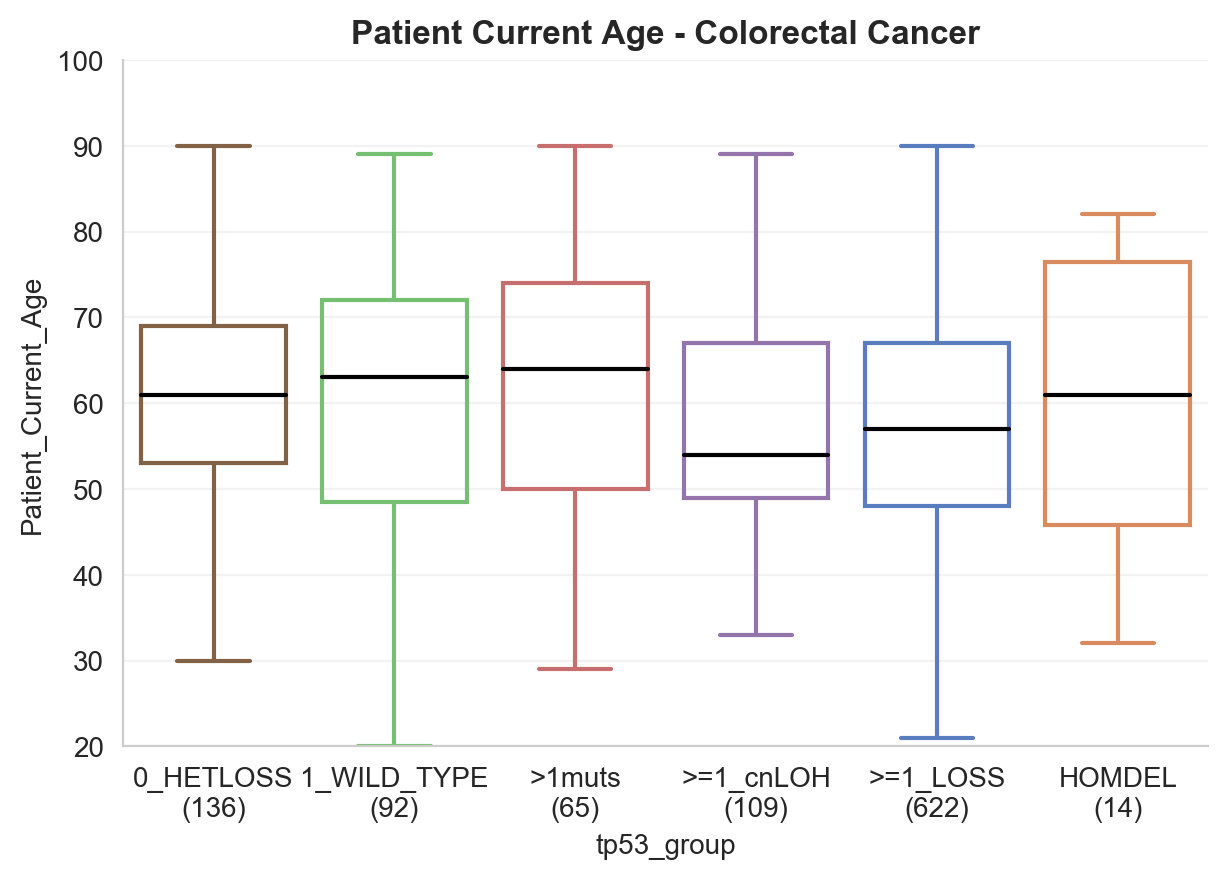

,0,1,2
0,,size,Patient_Current_Age
1,1_WILD_TYPE,92,63
2,>=1_cnLOH,109,54
3,,Statistics,p-value
4,,1.91238,0.0558271


In [52]:
fig, ax = boxplot_sampletype(df=master_no_wgd_cancer,
                  group='tp53_group',
                  palette=palette,
                  order=group_list,
                  metrics='Patient_Current_Age',
                  figsize=(7,10),
                  title='Patient Current Age - {}'.format(cancer),
                  xlim=[20,100])
plt.show()

get_statistics(df=master_no_wgd_cancer,
               group='tp53_group',
               metrics='Patient_Current_Age',
               group_list=['1_WILD_TYPE', '>=1_cnLOH'])

### Sex

,count
Sex,
Male,762
Female,684


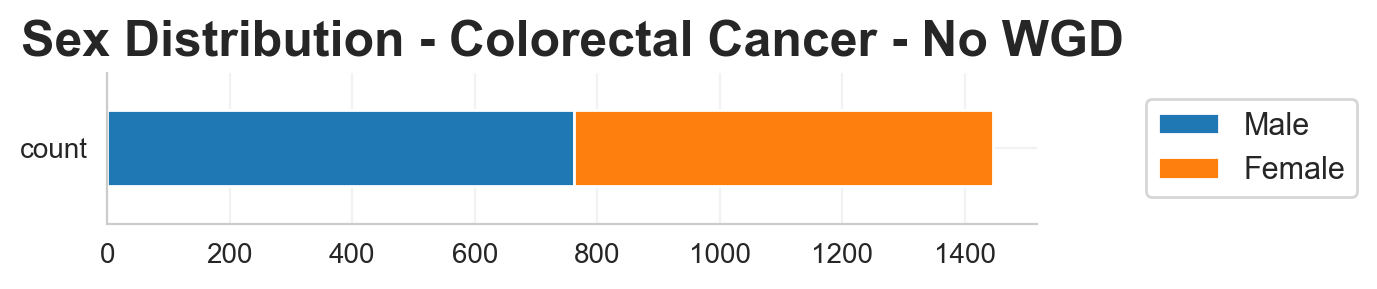

In [129]:
h = get_groupby(master_no_wgd_cancer,'Sex', 'count').sort_values(by='count', ascending=False)
display(h)

h = h.T
h = h[['Male', 'Female']]
fig = plt.figure(figsize=(6,1))
ax = plt.subplot()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

h_plot = h.plot(kind = 'barh', stacked=True, yticks=[], ax=ax)
ax.legend(['Male', 'Female'],loc='center left', bbox_to_anchor=(1.1, 0.5), fontsize=11)
ax.set_title('Sex Distribution - {} - No WGD'.format(cancer), weight='bold', fontsize=18)

plt.show()

### Survival Analysis

In [105]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [106]:
data = master_no_wgd_cancer.dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)

data = data[['tp53_group', 'tp53_res_group', 'Overall Survival Status 0/1', 'Overall_Survival_Months']]

ix1 = data['tp53_res_group'] == 'tp53_res'
ix2 = data['tp53_res_group'] == 'no_tp53_res'

T_exp, E_exp = data.loc[ix1, 'Overall_Survival_Months'], data.loc[ix1, 'Overall Survival Status 0/1']
T_con, E_con = data.loc[ix2, 'Overall_Survival_Months'], data.loc[ix2, 'Overall Survival Status 0/1']

results = logrank_test(T_exp, T_con, event_observed_A=E_exp, event_observed_B=E_con)
results.print_summary()

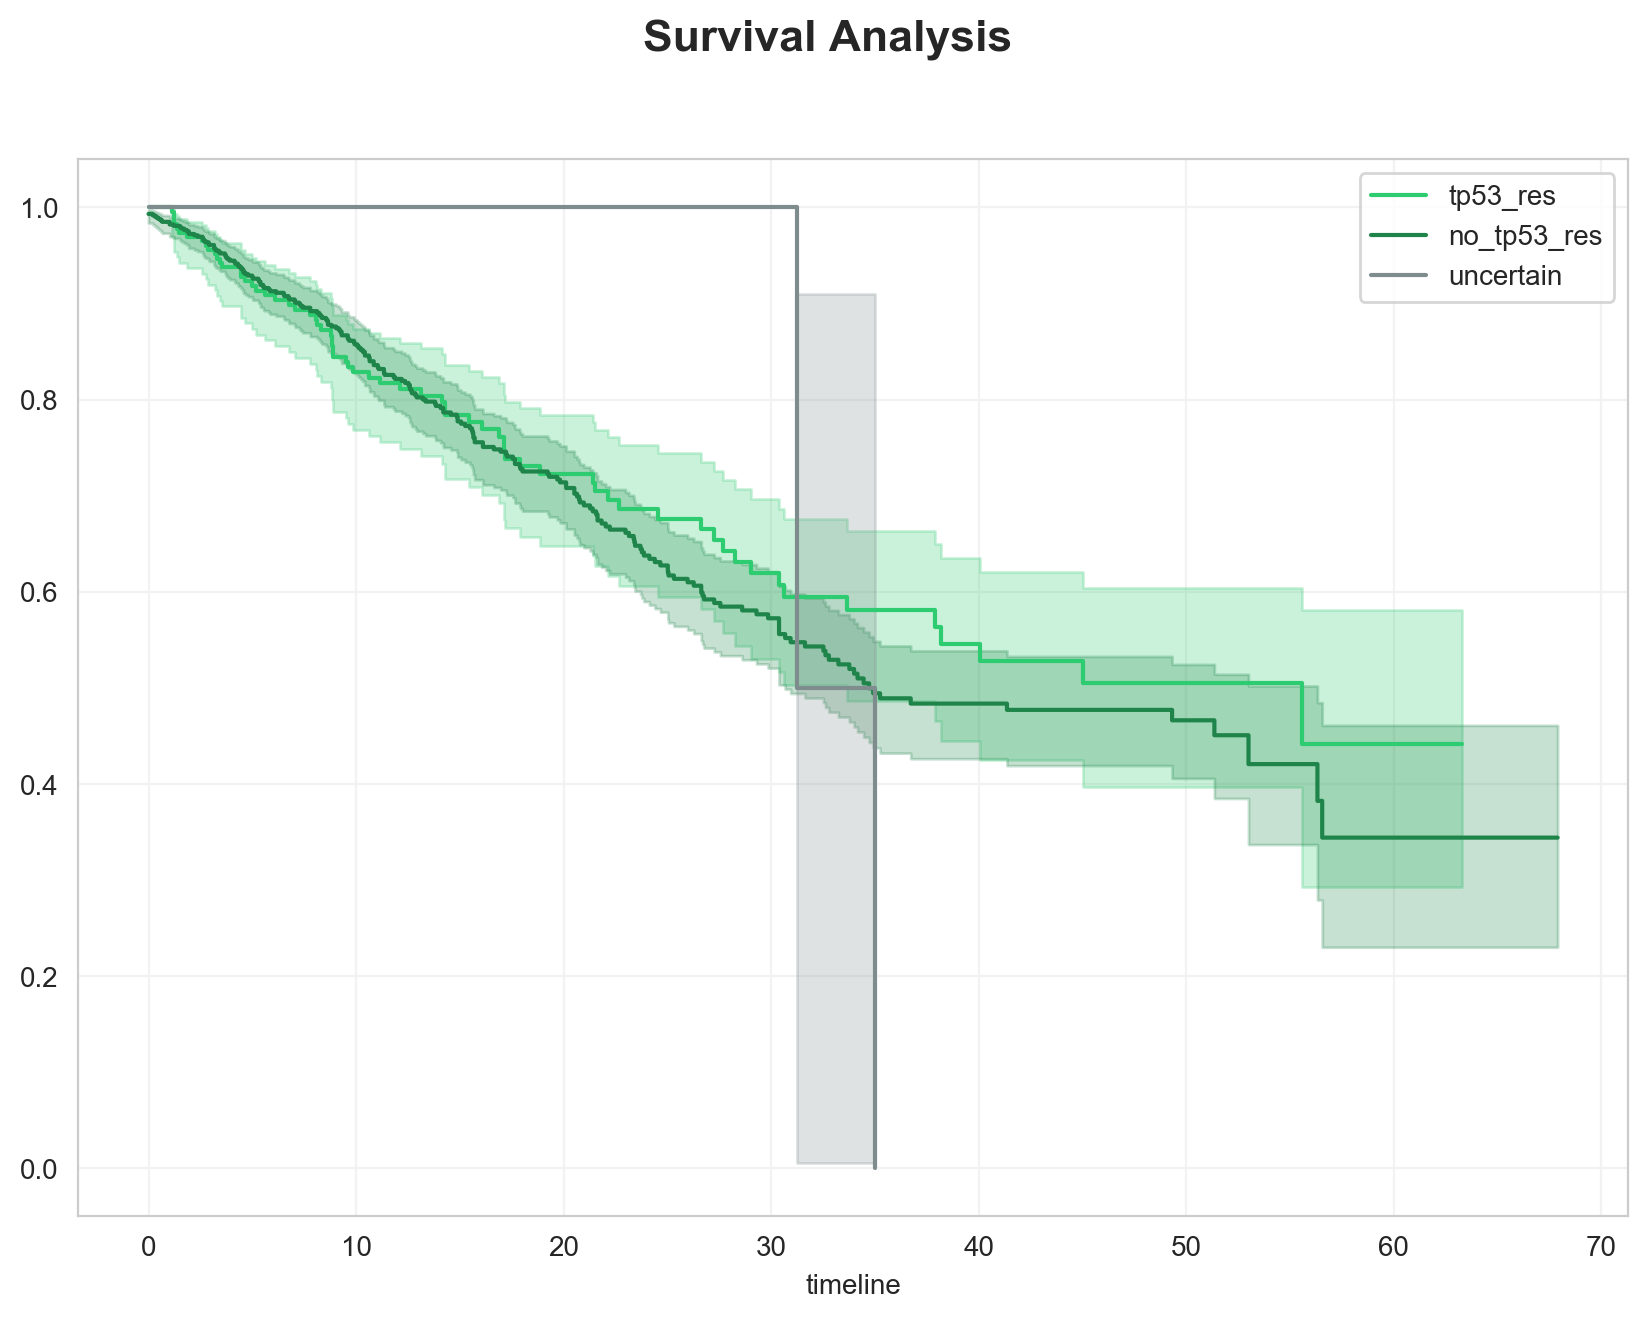

In [73]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis', fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(res_group_list, range(len(res_group_list))):
    data = master_no_wgd_cancer[master_no_wgd_cancer['tp53_res_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = res_palette_list[i], ax=ax)
plt.show()

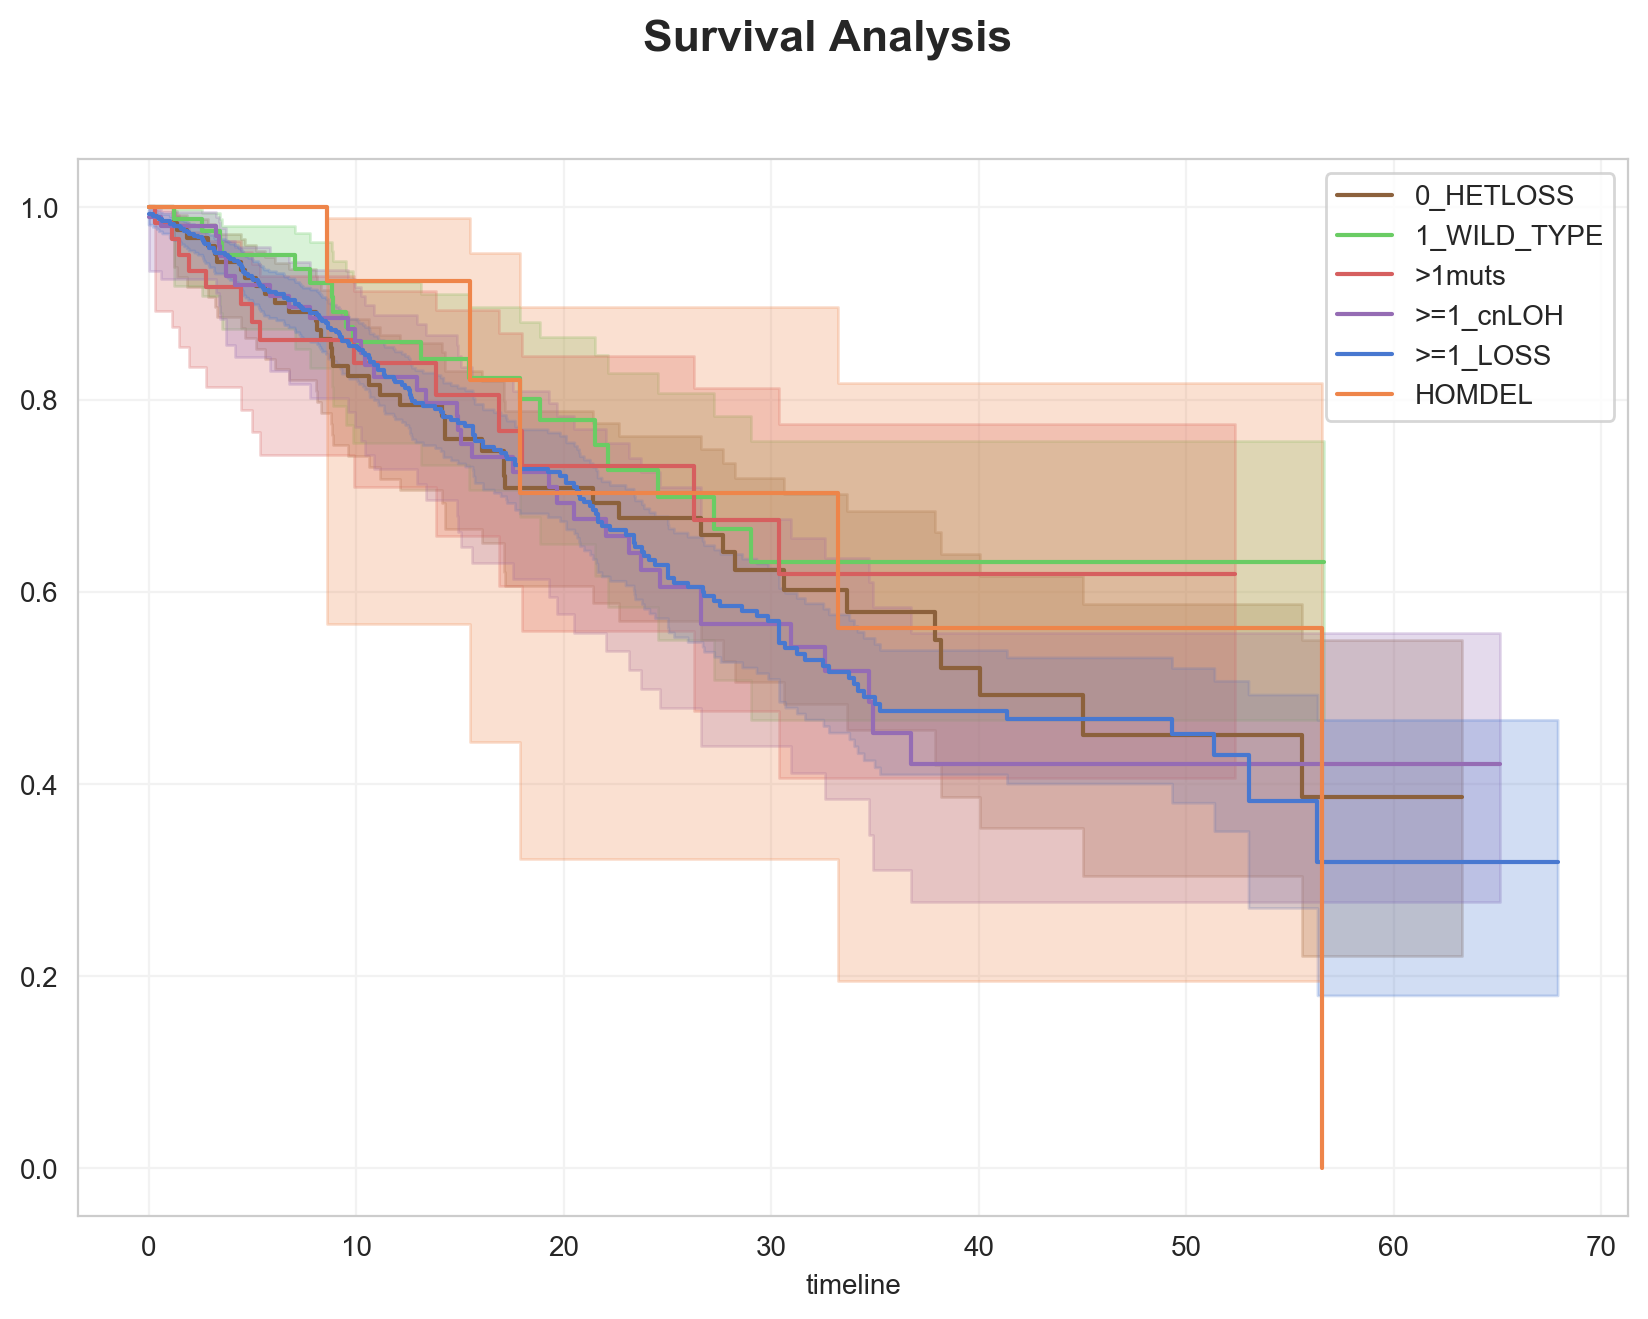

In [72]:
from lifelines import KaplanMeierFitter

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
fig.suptitle('Survival Analysis', fontsize=16, weight='bold')
kmf = KaplanMeierFitter()

for group,i in zip(group_list, range(len(group_list))):
    data = master_no_wgd_cancer[master_no_wgd_cancer['tp53_group'] == group].dropna(subset=['Overall_Survival_Months', 'Overall_Survival_Status'])
    data['Overall Survival Status 0/1'] = data.apply(lambda x: 1 if x['Overall_Survival_Status'] == 'DECEASED' else 0, axis=1)
    kmf.fit(np.array(data['Overall_Survival_Months']), event_observed=np.array(data['Overall Survival Status 0/1']),  label= group)
    kmf.plot_survival_function(color = palette_list[i], ax=ax)
plt.show()